En este notebook se va a hacer el ANALISIS DESCRIPTIVO del TFM

In [1]:
import pandas as pd

En el notebook anterior se ha decidido por usabilidad y por numero de datos faltantes que se van a borrar las siguientes columnas

In [2]:
archivo = './ahogamientos-completo-procesado.csv'
data  = pd.read_csv(archivo, sep=',', encoding='utf-8')
data2 = data.copy()
a_categorica = [ 'Localidad',
 'Provincia',
 'CCAA',
 'Vigilancia',
 'Actividad',
 'Deteccion',
 'Intervencion',
 'Localizacion',
 'Riesgo',
 'Sexo',
 'Nacionalidad',
 'Origen',
 'Causa',
 'FactorRiesgo',
 'Antecedentes',
 'PrimerInterviniente',
 'MaterialRescate',
 'Extraccion',
 'TipoAhogamiento',
 'Reanimacion',
 'Pronostico']
a_numerica = ['IdAhogado', 'IdPersona', 'Edad']     
a_fecha = ['Fecha', 'Hora']
for i in a_categorica:
    data2[i] = data2[i].astype('category')

for i in a_numerica:
    data2[i] = pd.to_numeric(data2[i], errors='coerce').dropna().astype('int64')
    
data2["Fecha"] = data2["Fecha"].str.split("T").str[0]

data2["Hora"] = data2["Hora"].str.split("T").str[1].str.replace("Z", "")

data2["Fecha"] = pd.to_datetime(data2["Fecha"], errors="coerce")

data2["Hora"] = pd.to_datetime(data2["Hora"], format="%H:%M:%S", errors="coerce").dt.time

In [3]:

columnas_a_eliminar = ['Titular', 'Noticia', 'Enlace1', 'Enlace2', 'Enlace3',
                        'Enlace4', 'Enlace5', 'Latitud', 'Longitud', 'Maps',
                        'Tweet', 'Notas', 'Campo1', 'Campo2',
                        'Antecedentes', 'MaterialRescate', 'Origen']
data2 = data2.drop(columnas_a_eliminar, axis=1)


In [4]:
num_columns = data2.shape[1]
print(f"El número de columnas en data2 es: {num_columns}")

El número de columnas en data2 es: 23


In [5]:
from sklearn.preprocessing import KBinsDiscretizer

numero_bins = 3
col_edad = data2[['Edad']].dropna()

kbin = KBinsDiscretizer(n_bins=numero_bins, encode='ordinal', strategy='quantile')
_= kbin.fit_transform(col_edad).astype(int)

bins = [0]
for i in range(1, len(kbin.bin_edges_[0])):
    bins.append(round(kbin.bin_edges_[0][i]))
        

labels = [f'Menor de {bins[1]} años'] 
labels += [f'Entre {bins[i]} y {bins[i+1]} años' for i in range(1, len(bins) - 2)] 
labels.append(f'Mayor de {bins[-2]} años') 

data2['Edad_discretizada'] = pd.cut(data2['Edad'], bins=bins, labels=labels)
data2['Edad_discretizada'] = data2['Edad_discretizada'].cat.add_categories(['Sin datos']).fillna('Sin datos')



PCA? se puede hacer con variables categoricas? .> NO


Clustering

Se ha visto que el metodo para hacer clustering con variables categoricas en python es Kmodes.


TEORIA




In [30]:
from kmodes.kmodes import KModes

columnas_categoricas = data2.select_dtypes(include='category').columns

X = data2[columnas_categoricas]

X_encoded = X.apply(lambda x: x.cat.codes)

In [31]:
X_encoded.head()

Localidad  Provincia  CCAA  Vigilancia  Actividad  Deteccion  Intervencion  \
0       2275         15     0           2          8          0             2   
1       3929         50     4           0          5          6             3   
2        533         31     4           3         14          1             1   
3       4267         21     4           0         14          6             3   
4       3748         21     4           0         14          5             6   

   Localizacion  Riesgo  Sexo  Nacionalidad  Causa  FactorRiesgo  \
0             4       4     0            34      1             8   
1             9       1     0             1     17            10   
2            14       0     0            80     17            10   
3            14       0     0            40     17            10   
4            14       0     0            40     17            10   

   PrimerInterviniente  Extraccion  TipoAhogamiento  Reanimacion  Pronostico  \
0                    0           2                3            7           0   
1                   10          12                8            2           0   
2                    2           1                0            8           0   
3                   10          12                0            2           0   
4                    2          12                8            2           0   

   Edad_discretizada  
0                  0  
1                  1  
2                  1  
3                  2  
4                  2

In [32]:


k = 3

km = KModes(n_clusters=k, init='Huang', n_init=5, verbose=0, random_state=42)
clusters = km.fit_predict(X_encoded)

data2['Cluster'] = clusters

print("\nCoste:")
print(km.cost_)

print("\nTamaño de cada cluster:")
print(data2['Cluster'].value_counts())



Coste:
104349.0

Tamaño de cada cluster:
Cluster
0    5053
1    3384
2    3067
Name: count, dtype: int64


el coste se puede interpretar de la siguiente manera

¿Qué mide el cost en K-Modes?
El costo total (cost_) es:

La suma del número de atributos distintos entre cada muestra y el centroide de su cluster.

Es decir, por cada fila (observación), compara con su centroide:

Si una columna es distinta al centroide → suma 1.

Luego lo suma para todas las columnas y todas las filas.

In [9]:
cat_columns = data2.select_dtypes(include=['category']).shape[1]
print(f"El número de columnas categóricas en data2 es: {cat_columns}")

avg_cost = km.cost_ / X_encoded.shape[0]
print(f"Diferencias promedio por fila: {avg_cost:.2f}")

El número de columnas categóricas en data2 es: 19
Diferencias promedio por fila: 9.07


Esto quiere decir que de media de 19 columnas hay 9 filas que no se parecen al cluster y otras 10 de si

Como veo cual es el numero optimo de clusters? para ello uso el metodo del codo

VER TEORIA



from kmodes.kmodes import KModes
import matplotlib.pyplot as plt

costs = []
K = range(1, 50, 5)

for k in K:
    km = KModes(n_clusters=k, init='Huang', n_init=5, verbose=0)
    km.fit_predict(X_encoded)
    costs.append(km.cost_)

plt.plot(K, costs, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Costo (disimilitud total)')
plt.title('Método del Codo para K-Modes')
plt.show()


aqui puedo probar que es mejor si huan o cao

tecnica del codo numero clusters optimo

ccON FACTOR RIESGO


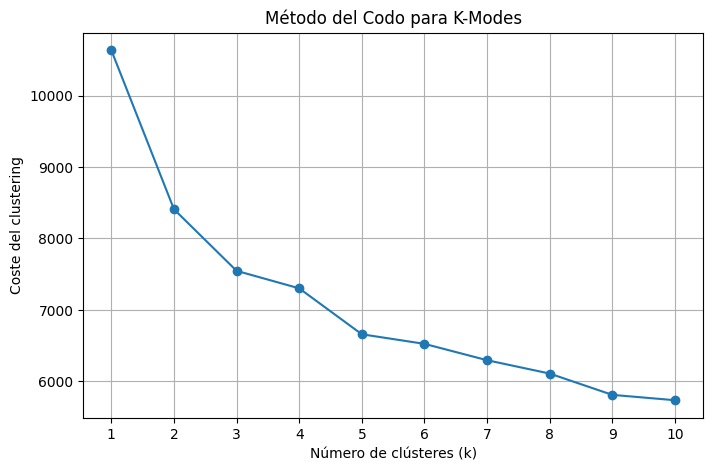

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from kmodes.kmodes import KModes

columnas_objetivo1 = ['Edad_discretizada', 'CCAA','FactorRiesgo', 'Causa', 'TipoAhogamiento','Pronostico']


#columnas_objetivo1 = ['Edad_discretizada', 'CCAA', 'Causa', 'TipoAhogamiento','Pronostico']

data_filtrada = data2[columnas_objetivo1].copy()

data_filtrada = data_filtrada[~data_filtrada.isin(['Sin datos']).any(axis=1)].copy()

X = data_filtrada.astype(str)

costes = []
k_values = range(1, 11)

for k in k_values:
    km = KModes(n_clusters=k, init='Huang', n_init=5, verbose=0, random_state=42)
    km.fit(X)
    costes.append(km.cost_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, costes, marker='o')
plt.xlabel('Número de clústeres (k)')
plt.ylabel('Coste del clustering')
plt.title('Método del Codo para K-Modes')
plt.xticks(k_values)
plt.grid(True)
plt.show()


In [56]:
data_filtered = data2[data2['FactorRiesgo'] != 'Sin datos']

porcentaje_por_grupo = data_filtered['Edad_discretizada'].value_counts(normalize=True) *100

print("Porcentaje de cada grupo de edad después de eliminar 'Sin datos' en FactorRiesgo:")
print(porcentaje_por_grupo)

Porcentaje de cada grupo de edad después de eliminar 'Sin datos' en FactorRiesgo:
Edad_discretizada
Mayor de 60 años      59.956501
Menor de 32 años      23.417110
Entre 32 y 60 años    16.626390
Name: proportion, dtype: float64


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from textwrap import wrap
from kmodes.kmodes import KModes

# ---------- FUNCIONES -----------

def guardar_dataframe_como_imagen(df, nombre_archivo='cluster_1.png'):
    fig, ax = plt.subplots(figsize=(14, 6 + 0.6 * len(df)))  # Ajusta el alto según número de filas
    ax.axis('off')

    # Ajustar texto largo en celdas
    wrapped_cell_text = [
        ['\n'.join(wrap(str(cell), 25)) for cell in row]
        for row in df.values
    ]
    wrapped_col_labels = ['\n'.join(wrap(str(col), 20)) for col in df.columns]
    wrapped_row_labels = ['\n'.join(wrap(str(idx), 15)) for idx in df.index]

    tabla = ax.table(
        cellText=wrapped_cell_text,
        colLabels=wrapped_col_labels,
        rowLabels=wrapped_row_labels,
        cellLoc='center',
        loc='center'
    )

    tabla.auto_set_font_size(False)
    tabla.set_fontsize(10)
    tabla.scale(1.2, 2)

    plt.tight_layout()
    plt.savefig(nombre_archivo, bbox_inches='tight', dpi=300)
    plt.close()

def resumen_por_cluster(df):
    resumen = []
    for c in sorted(df['Cluster'].unique()):
        cluster_data = df[df['Cluster'] == c]
        moda = cluster_data.mode(numeric_only=False).iloc[0]
        resumen.append(moda)
    resumen_df = pd.DataFrame(resumen)
    resumen_df.index = [f"Cluster {i}" for i in resumen_df['Cluster']]
    resumen_df = resumen_df.drop(columns=['Cluster'])  # Quitar columna de cluster

    try:
        display(resumen_df)
    except:
        print(resumen_df.to_string())
    return resumen_df

# ---------- CLUSTERING -----------

data_filtrada = data2[columnas_objetivo1].copy()

data_filtrada = data_filtrada[~data_filtrada.isin(['Sin datos']).any(axis=1)].copy()

total_original = 11504
total_usado = len(data_filtrada)
porcentaje_usado = (total_usado / total_original) * 100
print(f"\nSe usaron {total_usado} registros de {total_original} ({porcentaje_usado:.2f}%) tras eliminar 'Sin datos'.")

X = data_filtrada.astype(str)

k = 9
km = KModes(n_clusters=k, init='Huang', n_init=5, verbose=0, random_state=42)
clusters = km.fit_predict(X)

data_filtrada['Cluster'] = clusters

print(f"\nCoste total del clustering: {km.cost_}")
print("Tamaño de cada clúster:")
print(data_filtrada['Cluster'].value_counts())

resumen_clusters = resumen_por_cluster(data_filtrada)

guardar_dataframe_como_imagen(resumen_clusters, 'cluster_1.png')




Se usaron 2822 registros de 11504 (24.53%) tras eliminar 'Sin datos'.

Coste total del clustering: 5811.0
Tamaño de cada clúster:
Cluster
2    639
0    557
1    343
5    271
3    266
4    258
6    225
8    144
7    119
Name: count, dtype: int64


Edad_discretizada             CCAA  \
Cluster 0    Menor de 32 años  Cdad Valenciana   
Cluster 1    Menor de 32 años        Andalucía   
Cluster 2    Mayor de 60 años  Cdad Valenciana   
Cluster 3    Mayor de 60 años          Galicia   
Cluster 4    Mayor de 60 años  Cdad Valenciana   
Cluster 5  Entre 32 y 60 años         Canarias   
Cluster 6  Entre 32 y 60 años          Galicia   
Cluster 7    Menor de 32 años         Baleares   
Cluster 8    Mayor de 60 años         Canarias   

                                  FactorRiesgo  \
Cluster 0     Violación de normas de seguridad   
Cluster 1    Falta de supervisión o vigilancia   
Cluster 2  Edad, Enfermedad, Enfermedad Mental   
Cluster 3  Edad, Enfermedad, Enfermedad Mental   
Cluster 4  Edad, Enfermedad, Enfermedad Mental   
Cluster 5             Peligrosidad del entorno   
Cluster 6             Peligrosidad del entorno   
Cluster 7       Navegación, deportes acuáticos   
Cluster 8  Edad, Enfermedad, Enfermedad Mental   

                                                Causa  \
Cluster 0              Condiciones del medio acuático   
Cluster 1  Accidente, caída o zambullida accidentales   
Cluster 2  Accidente, caída o zambullida accidentales   
Cluster 3  Accidente, caída o zambullida accidentales   
Cluster 4          Enfermedad, ataque cardíaco o ACVA   
Cluster 5  Accidente, caída o zambullida accidentales   
Cluster 6              Condiciones del medio acuático   
Cluster 7  Accidente, caída o zambullida accidentales   
Cluster 8  Accidente, caída o zambullida accidentales   

                                      TipoAhogamiento  \
Cluster 0                          Perdida de Control   
Cluster 1  Ahogado con sintomas de aspiración de agua   
Cluster 2          Ahogamiento secundario a accidente   
Cluster 3                         Posible Ahogamiento   
Cluster 4         Ahogamiento secundario a enfermedad   
Cluster 5  Ahogado con sintomas de aspiración de agua   
Cluster 6                          Perdida de Control   
Cluster 7          Ahogamiento secundario a accidente   
Cluster 8                          Perdida de Control   

                          Pronostico  
Cluster 0  Rescate sin consecuencias  
Cluster 1         Ahogamiento mortal  
Cluster 2         Ahogamiento mortal  
Cluster 3         Ahogamiento mortal  
Cluster 4         Ahogamiento mortal  
Cluster 5         Ahogamiento mortal  
Cluster 6  Rescate sin consecuencias  
Cluster 7         Ahogamiento mortal  
Cluster 8  Rescate sin consecuencias

sIN FACTOR RIESGO

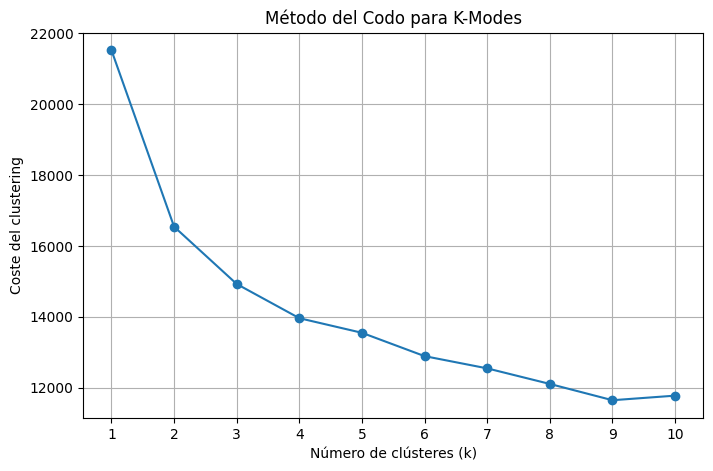

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from kmodes.kmodes import KModes

columnas_objetivo2 = ['Edad_discretizada', 'CCAA', 'Causa', 'TipoAhogamiento','Pronostico']

#si quito factorRiesgo entonces me separa en 3 edades
#columnas_objetivo1 = ['Edad_discretizada', 'CCAA', 'Causa', 'TipoAhogamiento','Pronostico']

data_filtrada = data2[columnas_objetivo2].copy()

data_filtrada = data_filtrada[~data_filtrada.isin(['Sin datos']).any(axis=1)].copy()

X = data_filtrada.astype(str)

costes = []
k_values = range(1, 11)

for k in k_values:
    km = KModes(n_clusters=k, init='Huang', n_init=5, verbose=0, random_state=42)
    km.fit(X)
    costes.append(km.cost_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, costes, marker='o')
plt.xlabel('Número de clústeres (k)')
plt.ylabel('Coste del clustering')
plt.title('Método del Codo para K-Modes')
plt.xticks(k_values)
plt.grid(True)
plt.savefig('codo_completo_sin_fr', bbox_inches='tight', dpi=150)
plt.show()


In [11]:
import pandas as pd
from kmodes.kmodes import KModes

data_filtrada = data2[columnas_objetivo2].copy()

data_filtrada = data_filtrada[~data_filtrada.isin(['Sin datos']).any(axis=1)].copy()

total_original = 11504
total_usado = len(data_filtrada)
porcentaje_usado = (total_usado / total_original) * 100
print(f"\nSe usaron {total_usado} registros de {total_original} ({porcentaje_usado:.2f}%) tras eliminar 'Sin datos'.")

X = data_filtrada.astype(str)

k = 9
km = KModes(n_clusters=k, init='Huang', n_init=5, verbose=0, random_state=42)
clusters = km.fit_predict(X)

data_filtrada['Cluster'] = clusters

print(f"\nCoste total del clustering: {km.cost_}")
print("Tamaño de cada clúster:")
print(data_filtrada['Cluster'].value_counts())

def resumen_por_cluster(df):
    resumen = []
    for c in sorted(df['Cluster'].unique()):
        cluster_data = df[df['Cluster'] == c]
        moda = cluster_data.mode(numeric_only=False).iloc[0]
        resumen.append(moda)
    resumen_df = pd.DataFrame(resumen)
    resumen_df.index = [f"Cluster {i}" for i in resumen_df['Cluster']]
    resumen_df = resumen_df.drop(columns=['Cluster'])  # Quitar columna de cluster

    try:
        display(resumen_df)
    except:
        print(resumen_df.to_string())

    return resumen_df

resumen_clusters = resumen_por_cluster(data_filtrada)
guardar_dataframe_como_imagen(resumen_clusters, 'cluster_completo_sin_fr.png')



Se usaron 6408 registros de 11504 (55.70%) tras eliminar 'Sin datos'.

Coste total del clustering: 11649.0
Tamaño de cada clúster:
Cluster
0    1438
1    1209
3     987
6     722
4     569
2     518
5     403
7     374
8     188
Name: count, dtype: int64


Edad_discretizada             CCAA  \
Cluster 0    Menor de 32 años        Andalucía   
Cluster 1  Entre 32 y 60 años          Galicia   
Cluster 2    Menor de 32 años         Baleares   
Cluster 3    Mayor de 60 años  Cdad Valenciana   
Cluster 4  Entre 32 y 60 años         Canarias   
Cluster 5    Mayor de 60 años          Galicia   
Cluster 6    Menor de 32 años        Andalucía   
Cluster 7  Entre 32 y 60 años  Cdad Valenciana   
Cluster 8    Mayor de 60 años  Cdad Valenciana   

                                                Causa  \
Cluster 0  Accidente, caída o zambullida accidentales   
Cluster 1              Condiciones del medio acuático   
Cluster 2                                   Naufragio   
Cluster 3  Accidente, caída o zambullida accidentales   
Cluster 4              Incidente o accidente de buceo   
Cluster 5          Enfermedad, ataque cardíaco o ACVA   
Cluster 6              Condiciones del medio acuático   
Cluster 7              Condiciones del medio acuático   
Cluster 8              Condiciones del medio acuático   

                                      TipoAhogamiento  \
Cluster 0  Ahogado con sintomas de aspiración de agua   
Cluster 1                          Perdida de Control   
Cluster 2                          Perdida de Control   
Cluster 3          Ahogamiento secundario a accidente   
Cluster 4          Ahogamiento secundario a accidente   
Cluster 5         Ahogamiento secundario a enfermedad   
Cluster 6                          Perdida de Control   
Cluster 7  Ahogado con sintomas de aspiración de agua   
Cluster 8                          Perdida de Control   

                                        Pronostico  
Cluster 0                       Ahogamiento mortal  
Cluster 1                Rescate sin consecuencias  
Cluster 2                Rescate sin consecuencias  
Cluster 3                       Ahogamiento mortal  
Cluster 4                       Ahogamiento mortal  
Cluster 5                       Ahogamiento mortal  
Cluster 6                Rescate sin consecuencias  
Cluster 7                       Ahogamiento mortal  
Cluster 8  Rescate y traslado a supervisión médica

para incluyendo los sin datos

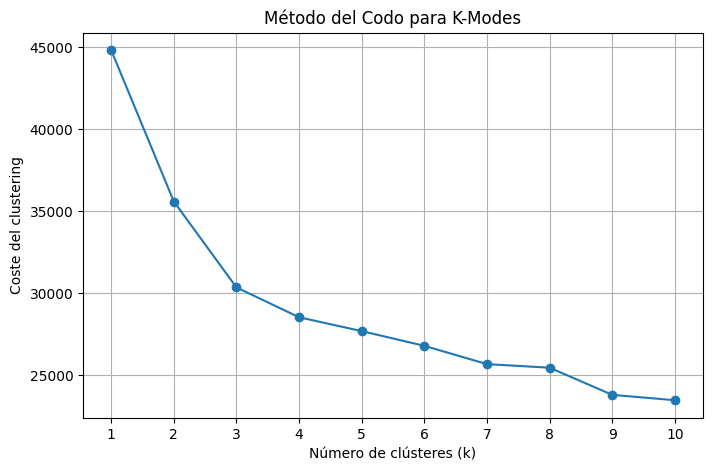

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from kmodes.kmodes import KModes

data_filtrada = data2[columnas_objetivo1].copy()

X = data_filtrada.astype(str)

costes = []
k_values = range(1, 11)

for k in k_values:
    km = KModes(n_clusters=k, init='Huang', n_init=5, verbose=0, random_state=42)
    km.fit(X)
    costes.append(km.cost_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, costes, marker='o')
plt.xlabel('Número de clústeres (k)')
plt.ylabel('Coste del clustering')
plt.title('Método del Codo para K-Modes')
plt.xticks(k_values)
plt.grid(True)
plt.show()


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from kmodes.kmodes import KModes

columnas_objetivo1 = ['Edad_discretizada', 'FactorRiesgo', 'Causa', 'TipoAhogamiento', 'Pronostico']
data_filtrada = data2[columnas_objetivo1].copy()

total_original = 11504
total_usado = len(data_filtrada)
porcentaje_usado = (total_usado / total_original) * 100
print(f"\nSe usaron {total_usado} registros de {total_original} ({porcentaje_usado:.2f}%) tras eliminar 'Sin datos'.")

X = data_filtrada.astype(str)

k = 3
km = KModes(n_clusters=k, init='Huang', n_init=5, verbose=0, random_state=42)
clusters = km.fit_predict(X)

data_filtrada['Cluster'] = clusters

print(f"\nCoste total del clustering: {km.cost_}")
print("Tamaño de cada clúster:")
print(data_filtrada['Cluster'].value_counts())

def resumen_por_cluster(df):
    resumen = []
    for c in sorted(df['Cluster'].unique()):
        cluster_data = df[df['Cluster'] == c]
        moda = cluster_data.mode(numeric_only=False).iloc[0]
        resumen.append(moda)
    resumen_df = pd.DataFrame(resumen)
    resumen_df.index = [f"Cluster {i}" for i in resumen_df['Cluster']]
    resumen_df = resumen_df.drop(columns=['Cluster'])
    return resumen_df

def guardar_dataframe_como_imagen(df, nombre_archivo='resumen_clusters.png'):
    fig, ax = plt.subplots(figsize=(12, 3 + 0.4 * len(df)))  # ajusta alto dinámicamente
    ax.axis('off')
    tabla = ax.table(cellText=df.values,
                     colLabels=df.columns,
                     rowLabels=df.index,
                     loc='center',
                     cellLoc='center')
    tabla.auto_set_font_size(False)
    tabla.set_fontsize(10)
    tabla.scale(1.2, 1.5)
    plt.tight_layout()
    plt.savefig(nombre_archivo, bbox_inches='tight')
    plt.close()

resumen_clusters = resumen_por_cluster(data_filtrada)
guardar_dataframe_como_imagen(resumen_clusters, 'resumen_clusterssindatos.png')
print("\n✅ Imagen guardada como 'resumen_clusters.png'")



Se usaron 11504 registros de 11504 (100.00%) tras eliminar 'Sin datos'.


: 

ESTO ES EN EL ANEXO

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from kmodes.kmodes import KModes
from textwrap import wrap

columnas_objetivo = ['Edad_discretizada','FactorRiesgo' ,'Causa', 'CCAA','TipoAhogamiento','Pronostico']

data_filtrada = data2[columnas_objetivo].copy()

data_filtrada = data_filtrada[~data_filtrada.isin(['Sin datos']).any(axis=1)].copy()

grupo_joven = data_filtrada[data_filtrada['Edad_discretizada'] == 'Menor de 32 años'].copy()
grupo_adulto = data_filtrada[data_filtrada['Edad_discretizada'] == 'Entre 32 y 60 años'].copy()
grupo_mayor = data_filtrada[data_filtrada['Edad_discretizada'] == 'Mayor de 60 años'].copy()


In [10]:

def metodo_del_codo(grupo, nombre_grupo, max_clusters=7):
    X = grupo.drop(columns=['Edad_discretizada']).astype(str)
    costos = []

    for k in range(1, max_clusters + 1):
        km = KModes(n_clusters=k, init='Huang', n_init=5, verbose=0, random_state=42)
        km.fit_predict(X)
        costos.append(km.cost_)

    plt.figure(figsize=(7, 4))
    plt.plot(range(1, max_clusters + 1), costos, marker='o')
    plt.title(f"Método del Codo para {nombre_grupo}")
    plt.xlabel("Número de clústeres (k)")
    plt.ylabel("Coste del clustering")
    plt.grid(True)
    plt.savefig(f'codo_{nombre_grupo}.png', bbox_inches='tight', dpi=150)
    plt.show()


def aplicar_kmodes(grupo, k):
    X = grupo.drop(columns=['Edad_discretizada']).astype(str)

    km = KModes(n_clusters=k, init='Huang', n_init=5, verbose=0, random_state=42)
    clusters = km.fit_predict(X)

    grupo = grupo.copy()
    grupo['Cluster'] = clusters

    print(f"\nGrupo de edad: {grupo['Edad_discretizada'].iloc[0]}")
    print(f"Coste del clustering: {km.cost_}")
    print("Tamaño de cada clúster:")
    print(grupo['Cluster'].value_counts())

    return grupo



def resumen_clusters_por_grupo(df, nombre_grupo):
    resumen = []
    for c in sorted(df['Cluster'].unique()):
        cluster_data = df[df['Cluster'] == c]
        moda = cluster_data.mode(numeric_only=False).iloc[0]
        resumen.append(moda)

    resumen_df = pd.DataFrame(resumen)
    resumen_df.index = [f"{nombre_grupo} - Cluster {i}" for i in resumen_df['Cluster']]
    resumen_df = resumen_df.drop(columns=['Cluster'])

    try:
        display(resumen_df)
    except:
        print(resumen_df.to_string())

    return resumen_df



def guardar_dataframe_como_imagen(df, nombre_archivo='cluster_1.png'):
    fig, ax = plt.subplots(figsize=(14, 6 + 0.6 * len(df))) 
    ax.axis('off')

    wrapped_cell_text = [
        ['\n'.join(wrap(str(cell), 25)) for cell in row]
        for row in df.values
    ]
    wrapped_col_labels = ['\n'.join(wrap(str(col), 20)) for col in df.columns]
    wrapped_row_labels = ['\n'.join(wrap(str(idx), 15)) for idx in df.index]

    tabla = ax.table(
        cellText=wrapped_cell_text,
        colLabels=wrapped_col_labels,
        rowLabels=wrapped_row_labels,
        cellLoc='center',
        loc='center'
    )

    tabla.auto_set_font_size(False)
    tabla.set_fontsize(10)
    tabla.scale(1.2, 2)

    plt.tight_layout()
    plt.savefig(nombre_archivo, bbox_inches='tight', dpi=150)
    plt.close()


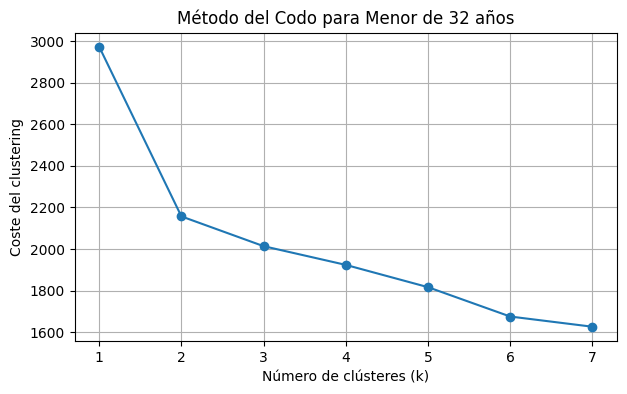

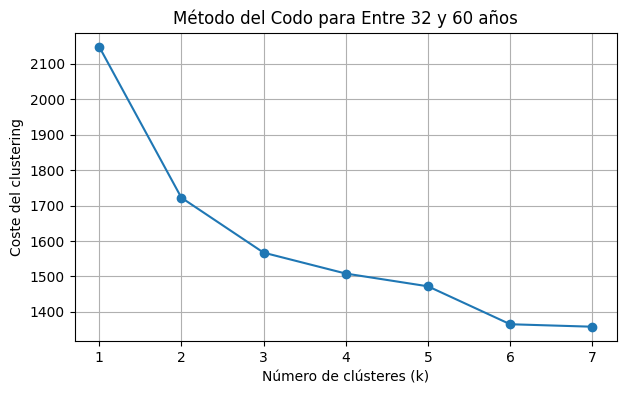

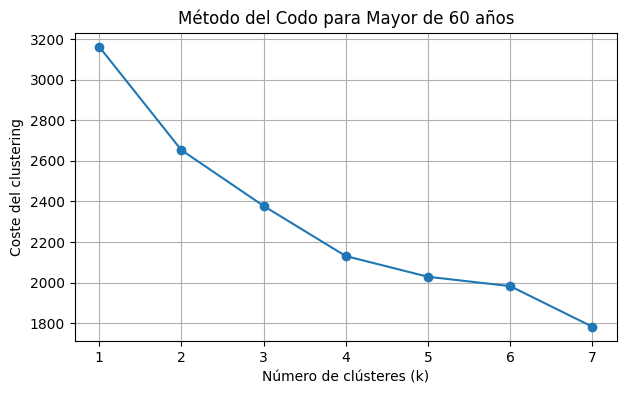

In [34]:

metodo_del_codo(grupo_joven, "Menor de 32 años")
metodo_del_codo(grupo_adulto, 'Entre 32 y 60 años')
metodo_del_codo(grupo_mayor, 'Mayor de 60 años')



In [35]:

grupo_joven_clustered = aplicar_kmodes(grupo_joven, k=2)
grupo_adulto_clustered = aplicar_kmodes(grupo_adulto, k=3)
grupo_mayor_clustered = aplicar_kmodes(grupo_mayor, k=5)

data_clustered = pd.concat([grupo_joven_clustered, grupo_adulto_clustered, grupo_mayor_clustered])



Grupo de edad: Menor de 32 años
Coste del clustering: 2157.0
Tamaño de cada clúster:
Cluster
0    542
1    347
Name: count, dtype: int64

Grupo de edad: Entre 32 y 60 años
Coste del clustering: 1567.0
Tamaño de cada clúster:
Cluster
0    282
1    194
2    165
Name: count, dtype: int64

Grupo de edad: Mayor de 60 años
Coste del clustering: 2029.0
Tamaño de cada clúster:
Cluster
0    621
3    245
1    162
2    143
4    121
Name: count, dtype: int64


In [36]:

resumen_joven = resumen_clusters_por_grupo(grupo_joven_clustered, "Joven")
guardar_dataframe_como_imagen(resumen_joven, 'cluster_joven.png')
resumen_adulto = resumen_clusters_por_grupo(grupo_adulto_clustered, "Adulto")
guardar_dataframe_como_imagen(resumen_adulto, 'cluster_adulto.png')
resumen_mayor = resumen_clusters_por_grupo(grupo_mayor_clustered, "Mayor")
guardar_dataframe_como_imagen(resumen_mayor, 'cluster_mayor.png')


Edad_discretizada                       FactorRiesgo  \
Joven - Cluster 0  Menor de 32 años           Peligrosidad del entorno   
Joven - Cluster 1  Menor de 32 años  Falta de supervisión o vigilancia   

                                                        Causa  \
Joven - Cluster 0              Condiciones del medio acuático   
Joven - Cluster 1  Accidente, caída o zambullida accidentales   

                              CCAA  \
Joven - Cluster 0  Cdad Valenciana   
Joven - Cluster 1        Andalucía   

                                              TipoAhogamiento  \
Joven - Cluster 0                          Perdida de Control   
Joven - Cluster 1  Ahogado con sintomas de aspiración de agua   

                                  Pronostico  
Joven - Cluster 0  Rescate sin consecuencias  
Joven - Cluster 1         Ahogamiento mortal

Edad_discretizada              FactorRiesgo  \
Adulto - Cluster 0  Entre 32 y 60 años  Peligrosidad del entorno   
Adulto - Cluster 1  Entre 32 y 60 años  Peligrosidad del entorno   
Adulto - Cluster 2  Entre 32 y 60 años  Peligrosidad del entorno   

                                                         Causa  \
Adulto - Cluster 0              Condiciones del medio acuático   
Adulto - Cluster 1              Condiciones del medio acuático   
Adulto - Cluster 2  Accidente, caída o zambullida accidentales   

                               CCAA  \
Adulto - Cluster 0  Cdad Valenciana   
Adulto - Cluster 1         Canarias   
Adulto - Cluster 2          Galicia   

                                               TipoAhogamiento  \
Adulto - Cluster 0                          Perdida de Control   
Adulto - Cluster 1  Ahogado con sintomas de aspiración de agua   
Adulto - Cluster 2          Ahogamiento secundario a accidente   

                                   Pronostico  
Adulto - Cluster 0  Rescate sin consecuencias  
Adulto - Cluster 1         Ahogamiento mortal  
Adulto - Cluster 2         Ahogamiento mortal

Edad_discretizada                         FactorRiesgo  \
Mayor - Cluster 0  Mayor de 60 años  Edad, Enfermedad, Enfermedad Mental   
Mayor - Cluster 1  Mayor de 60 años  Edad, Enfermedad, Enfermedad Mental   
Mayor - Cluster 2  Mayor de 60 años  Edad, Enfermedad, Enfermedad Mental   
Mayor - Cluster 3  Mayor de 60 años  Edad, Enfermedad, Enfermedad Mental   
Mayor - Cluster 4  Mayor de 60 años  Edad, Enfermedad, Enfermedad Mental   

                                                        Causa  \
Mayor - Cluster 0  Accidente, caída o zambullida accidentales   
Mayor - Cluster 1              Condiciones del medio acuático   
Mayor - Cluster 2              Condiciones del medio acuático   
Mayor - Cluster 3          Enfermedad, ataque cardíaco o ACVA   
Mayor - Cluster 4  Accidente, caída o zambullida accidentales   

                              CCAA  \
Mayor - Cluster 0          Galicia   
Mayor - Cluster 1  Cdad Valenciana   
Mayor - Cluster 2  Cdad Valenciana   
Mayor - Cluster 3  Cdad Valenciana   
Mayor - Cluster 4  Castilla y León   

                                              TipoAhogamiento  \
Mayor - Cluster 0          Ahogamiento secundario a accidente   
Mayor - Cluster 1                          Perdida de Control   
Mayor - Cluster 2  Ahogado con sintomas de aspiración de agua   
Mayor - Cluster 3         Ahogamiento secundario a enfermedad   
Mayor - Cluster 4                         Posible Ahogamiento   

                                  Pronostico  
Mayor - Cluster 0         Ahogamiento mortal  
Mayor - Cluster 1  Rescate sin consecuencias  
Mayor - Cluster 2         Ahogamiento mortal  
Mayor - Cluster 3         Ahogamiento mortal  
Mayor - Cluster 4         Ahogamiento mortal

ESTE ES EL BUENO EL QUE PONGO EN EL INFORME

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from kmodes.kmodes import KModes
columnas_objetivo = ['Edad_discretizada','Causa', 'TipoAhogamiento','Pronostico']

data_filtrada = data2[columnas_objetivo].copy()

data_filtrada = data_filtrada[~data_filtrada.isin(['Sin datos']).any(axis=1)].copy()

grupo_joven = data_filtrada[data_filtrada['Edad_discretizada'] == 'Menor de 32 años'].copy()
grupo_adulto = data_filtrada[data_filtrada['Edad_discretizada'] == 'Entre 32 y 60 años'].copy()
grupo_mayor = data_filtrada[data_filtrada['Edad_discretizada'] == 'Mayor de 60 años'].copy()


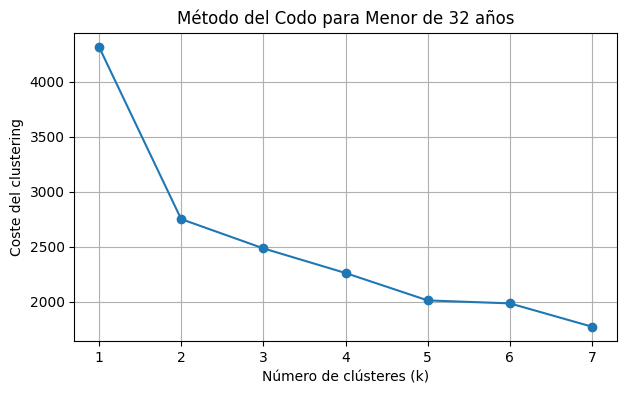

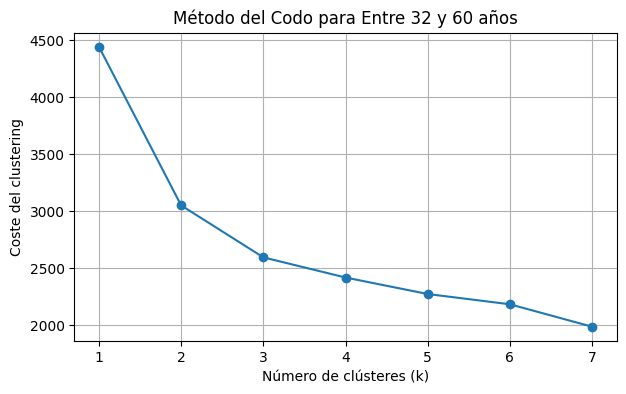

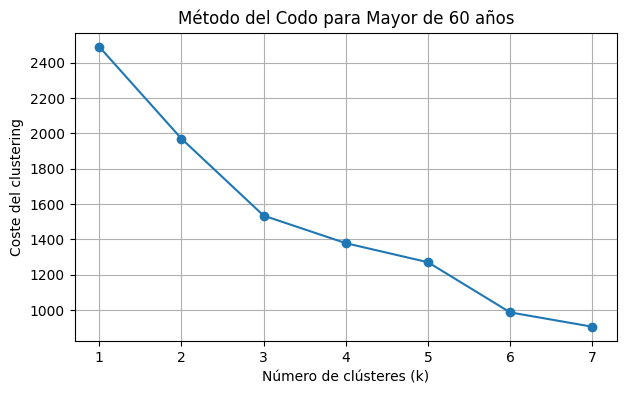

In [29]:

metodo_del_codo(grupo_joven, "Menor de 32 años")
metodo_del_codo(grupo_adulto, 'Entre 32 y 60 años')
metodo_del_codo(grupo_mayor, 'Mayor de 60 años')



In [30]:

grupo_joven_clustered = aplicar_kmodes(grupo_joven, k=2)
grupo_adulto_clustered = aplicar_kmodes(grupo_adulto, k=3)
grupo_mayor_clustered = aplicar_kmodes(grupo_mayor, k=4)

data_clustered = pd.concat([grupo_joven_clustered, grupo_adulto_clustered, grupo_mayor_clustered])



Grupo de edad: Menor de 32 años
Coste del clustering: 2751.0
Tamaño de cada clúster:
Cluster
0    1661
1     939
Name: count, dtype: int64

Grupo de edad: Entre 32 y 60 años
Coste del clustering: 2596.0
Tamaño de cada clúster:
Cluster
0    974
1    955
2    355
Name: count, dtype: int64

Grupo de edad: Mayor de 60 años
Coste del clustering: 1378.0
Tamaño de cada clúster:
Cluster
0    800
2    273
1    253
3    198
Name: count, dtype: int64


In [31]:

resumen_joven = resumen_clusters_por_grupo(grupo_joven_clustered, "Joven")
guardar_dataframe_como_imagen(resumen_joven, 'cluster_joven2.png')
resumen_adulto = resumen_clusters_por_grupo(grupo_adulto_clustered, "Adulto")
guardar_dataframe_como_imagen(resumen_adulto, 'cluster_adulto2.png')
resumen_mayor = resumen_clusters_por_grupo(grupo_mayor_clustered, "Mayor")
guardar_dataframe_como_imagen(resumen_mayor, 'cluster_mayor2.png')


Edad_discretizada  \
Joven - Cluster 0  Menor de 32 años   
Joven - Cluster 1  Menor de 32 años   

                                                        Causa  \
Joven - Cluster 0              Condiciones del medio acuático   
Joven - Cluster 1  Accidente, caída o zambullida accidentales   

                                              TipoAhogamiento  \
Joven - Cluster 0                          Perdida de Control   
Joven - Cluster 1  Ahogado con sintomas de aspiración de agua   

                                  Pronostico  
Joven - Cluster 0  Rescate sin consecuencias  
Joven - Cluster 1         Ahogamiento mortal

Edad_discretizada  \
Adulto - Cluster 0  Entre 32 y 60 años   
Adulto - Cluster 1  Entre 32 y 60 años   
Adulto - Cluster 2  Entre 32 y 60 años   

                                                         Causa  \
Adulto - Cluster 0              Condiciones del medio acuático   
Adulto - Cluster 1  Accidente, caída o zambullida accidentales   
Adulto - Cluster 2              Condiciones del medio acuático   

                                               TipoAhogamiento  \
Adulto - Cluster 0                          Perdida de Control   
Adulto - Cluster 1          Ahogamiento secundario a accidente   
Adulto - Cluster 2  Ahogado con sintomas de aspiración de agua   

                                   Pronostico  
Adulto - Cluster 0  Rescate sin consecuencias  
Adulto - Cluster 1         Ahogamiento mortal  
Adulto - Cluster 2         Ahogamiento mortal

Edad_discretizada  \
Mayor - Cluster 0  Mayor de 60 años   
Mayor - Cluster 1  Mayor de 60 años   
Mayor - Cluster 2  Mayor de 60 años   
Mayor - Cluster 3  Mayor de 60 años   

                                                        Causa  \
Mayor - Cluster 0  Accidente, caída o zambullida accidentales   
Mayor - Cluster 1              Condiciones del medio acuático   
Mayor - Cluster 2          Enfermedad, ataque cardíaco o ACVA   
Mayor - Cluster 3  Accidente, caída o zambullida accidentales   

                                              TipoAhogamiento  \
Mayor - Cluster 0          Ahogamiento secundario a accidente   
Mayor - Cluster 1  Ahogado con sintomas de aspiración de agua   
Mayor - Cluster 2         Ahogamiento secundario a enfermedad   
Mayor - Cluster 3                          Perdida de Control   

                                                Pronostico  
Mayor - Cluster 0                       Ahogamiento mortal  
Mayor - Cluster 1                       Ahogamiento mortal  
Mayor - Cluster 2                       Ahogamiento mortal  
Mayor - Cluster 3  Rescate y traslado a supervisión médica

In [55]:
data_valid_factor_riesgo = data2[data2['FactorRiesgo'] != 'Sin datos']
data_valid_factor_riesgo.shape


(4562, 26)

In [52]:
4562/11504

0.39655771905424203

HACERLO INCLUYENDO SIN DATOS?


### Reglas de asociacion

Vamos a usar el algoritmo apriori en pyhton que se usa con la libreria *mlxtend* con TransactionEncoder

En primer lugar, vamos a usar el formato TRANSACTIONS para no tener que codificarlos.

Por ello en vez de ser un dataframe ahora es una lista con los valores que tiene cada fila.





vamos a generar reglas solamente con als columnas que nos interesan que de momento son:

['Edad_discretizada','FactorRiesgo', 'Localidad', 'Causa','Localizacion', 'TipoAhogamiento']  


MOTIVO: en apriori se eliminan la creacion d reglas con variables que estan interrelacionadas y ya que vemos que Reanimacion y Pronostico estan relacionadas y por eso nos dan un support tan grande, por ello el apriori se va a hacer con variables escogidas cuidadosamente
Es decir, no nos interesa que salgan relaciones que son obvias

Ver notas

VER SI TENEMOS QUE PONER MAS COLUMNAS

In [18]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

cols = ['Edad_discretizada','FactorRiesgo', 'Localizacion', 'Causa', 'TipoAhogamiento']  
#cols = ['Edad_discretizada','FactorRiesgo', 'CCAA','Localizacion', 'Causa', 'TipoAhogamiento']  

data2.head()  



IdAhogado      Fecha                  Localidad     Provincia       CCAA  \
0        144 2013-01-01                    Iznajar       Córdoba  Andalucía   
1        146 2013-09-01          Puerto de la Cruz      Tenerife   Canarias   
2        147 2013-05-01                   Arrecife     Lanzarote   Canarias   
3        148 2013-05-01  San Bartolomé de Tirajana  Gran Canaria   Canarias   
4        150 2013-06-01           Playa del Inglés  Gran Canaria   Canarias   

       Hora                Vigilancia                Actividad  \
0  09:40:00               No vigilado  Circulación en vehiculo   
1  15:36:00  En horario de vigilancia           Buceo a pulmon   
2  16:00:00                 Sin datos      Natación recreativa   
3  15:35:00  En horario de vigilancia      Natación recreativa   
4  15:35:00  En horario de vigilancia      Natación recreativa   

                      Deteccion  \
0  Acompañante, familiar, amigo   
1        Socorrista en servicio   
2                     Ciudadano   
3        Socorrista en servicio   
4                     Sin datos   

                                        Intervencion  ...  Edad Nacionalidad  \
0                            Recuperación de cadaver  ...  19.0       España   
1  Rescate por Socorristas o personas adiestradas...  ...  59.0     Alemania   
2          Asistencia por transeúntes no adiestrados  ...  44.0  Reino Unido   
3  Rescate por Socorristas o personas adiestradas...  ...  67.0      Francia   
4  Rescate y atención in situ por personal de sal...  ...  67.0      Francia   

                                        Causa              FactorRiesgo  \
0  Accidente, caída o zambullida accidentales  Peligrosidad del entorno   
1                                   Sin datos                 Sin datos   
2                                   Sin datos                 Sin datos   
3                                   Sin datos                 Sin datos   
4                                   Sin datos                 Sin datos   

            PrimerInterviniente                         Extraccion  \
0  Acompañante, familiar, amigo  Cuerpo de Seguridad o Emergencias   
1                    Socorrista                         Socorrista   
2                     Ciudadano                          Ciudadano   
3                    Socorrista                         Socorrista   
4                     Ciudadano                         Socorrista   

                              TipoAhogamiento                   Reanimacion  \
0          Ahogamiento secundario a accidente       Recuperacion de cadaver   
1                         Posible Ahogamiento  RCP basica SOS y SVA por SEM   
2  Ahogado con sintomas de aspiración de agua                   SVA por SEM   
3  Ahogado con sintomas de aspiración de agua  RCP basica SOS y SVA por SEM   
4                         Posible Ahogamiento  RCP basica SOS y SVA por SEM   

           Pronostico   Edad_discretizada  
0  Ahogamiento mortal    Menor de 32 años  
1  Ahogamiento mortal  Entre 32 y 60 años  
2  Ahogamiento mortal  Entre 32 y 60 años  
3  Ahogamiento mortal    Mayor de 60 años  
4  Ahogamiento mortal    Mayor de 60 años  

[5 rows x 24 columns]

In [19]:

transactions = data2[cols].astype(str).apply(lambda row: [f"{col}={val}" for col, val in row.items()], axis=1).tolist()

print("Primeras transacciones:")
for i in range(5):
    print(transactions[i])


te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

print("\nDataFrame codificado:")
print(df_encoded.head())

Primeras transacciones:
['Edad_discretizada=Menor de 32 años', 'FactorRiesgo=Peligrosidad del entorno', 'Localizacion=Embalses, Pantanos', 'Causa=Accidente, caída o zambullida accidentales', 'TipoAhogamiento=Ahogamiento secundario a accidente']
['Edad_discretizada=Entre 32 y 60 años', 'FactorRiesgo=Sin datos', 'Localizacion=Piscinas de equipamientos hoteleros y similares', 'Causa=Sin datos', 'TipoAhogamiento=Posible Ahogamiento']
['Edad_discretizada=Entre 32 y 60 años', 'FactorRiesgo=Sin datos', 'Localizacion=Playas con vigilancia', 'Causa=Sin datos', 'TipoAhogamiento=Ahogado con sintomas de aspiración de agua']
['Edad_discretizada=Mayor de 60 años', 'FactorRiesgo=Sin datos', 'Localizacion=Playas con vigilancia', 'Causa=Sin datos', 'TipoAhogamiento=Ahogado con sintomas de aspiración de agua']
['Edad_discretizada=Mayor de 60 años', 'FactorRiesgo=Sin datos', 'Localizacion=Playas con vigilancia', 'Causa=Sin datos', 'TipoAhogamiento=Posible Ahogamiento']

DataFrame codificado:
   Causa=Acc

In [20]:

frequent_itemsets = apriori(df_encoded, min_support=0.05, use_colnames=True)

In [21]:
df_encoded.head()

Causa=Accidente de Trafico  \
0                       False   
1                       False   
2                       False   
3                       False   
4                       False   

   Causa=Accidente, caída o zambullida accidentales  Causa=Atrapamiento  \
0                                              True               False   
1                                             False               False   
2                                             False               False   
3                                             False               False   
4                                             False               False   

   Causa=Condiciones del medio acuático  Causa=Corriente de resaca  \
0                                 False                      False   
1                                 False                      False   
2                                 False                      False   
3                                 False                      False   
4                                 False                      False   

   Causa=DANA Octubre 2024  Causa=Drogas, alcohol, otros tóxicos  \
0                    False                                 False   
1                    False                                 False   
2                    False                                 False   
3                    False                                 False   
4                    False                                 False   

   Causa=Enfermedad, ataque cardíaco o ACVA  \
0                                     False   
1                                     False   
2                                     False   
3                                     False   
4                                     False   

   Causa=Excesiva confianza o asunción de riesgo  \
0                                          False   
1                                          False   
2                                          False   
3                                          False   
4                                          False   

   Causa=Falta de competencia acuática  ...  \
0                                False  ...   
1                                False  ...   
2                                False  ...   
3                                False  ...   
4                                False  ...   

   TipoAhogamiento=Ahogado sin sintomas de aspiración de agua  \
0                                              False            
1                                              False            
2                                              False            
3                                              False            
4                                              False            

   TipoAhogamiento=Ahogamiento secundario a accidente  \
0                                               True    
1                                              False    
2                                              False    
3                                              False    
4                                              False    

   TipoAhogamiento=Ahogamiento secundario a enfermedad  \
0                                              False     
1                                              False     
2                                              False     
3                                              False     
4                                              False     

   TipoAhogamiento=Distres Acuatico  \
0                             False   
1                             False   
2                             False   
3                             False   
4                             False   

   TipoAhogamiento=Muerte previa a inmersion  \
0                                      False   
1                                      False   
2                                      False   
3                                      False   
4                                      False   

   TipoAhogamiento=Perdida de Control

Vamos a considerar que el soporte minimo debe ser del 5%

El *soporte* quiere significar el numero de veces/porcentaje que debe aparecer una fila o transaccion para que se considere como frecuente, es decir para que se acepte

La *confidence* es una metrica usada para evaluar la calidad de las reglas de asociacion generadas que es el soporte de la union del antecedente y consecuente

In [22]:

print("Primeros 3 elementos de transactions:")
print(transactions[:3])

print("\nTipo de transactions:")
print(type(transactions))

Primeros 3 elementos de transactions:
[['Edad_discretizada=Menor de 32 años', 'FactorRiesgo=Peligrosidad del entorno', 'Localizacion=Embalses, Pantanos', 'Causa=Accidente, caída o zambullida accidentales', 'TipoAhogamiento=Ahogamiento secundario a accidente'], ['Edad_discretizada=Entre 32 y 60 años', 'FactorRiesgo=Sin datos', 'Localizacion=Piscinas de equipamientos hoteleros y similares', 'Causa=Sin datos', 'TipoAhogamiento=Posible Ahogamiento'], ['Edad_discretizada=Entre 32 y 60 años', 'FactorRiesgo=Sin datos', 'Localizacion=Playas con vigilancia', 'Causa=Sin datos', 'TipoAhogamiento=Ahogado con sintomas de aspiración de agua']]

Tipo de transactions:
<class 'list'>


En python no hay una funcion is.redundant como en R no osbtante vamos a crear una ver que nos da
y tambien vamos a eliminar las reglas espejo

In [23]:

def drop_mirror_rules(rules_df):
    seen = {}
    for _, row in rules_df.iterrows():
        ant = frozenset(row['antecedents'])
        con = frozenset(row['consequents'])
        pair = (ant, con)
        mirror = (con, ant)

        if mirror in seen:
            if row['lift'] > seen[mirror]['lift']:
                seen[pair] = row
                del seen[mirror] 
        elif pair not in seen:
            seen[pair] = row

    return pd.DataFrame(seen.values())

def drop_semantic_duplicates(rules_df):
    grouped = {}
    for _, row in rules_df.iterrows():
        total_items = frozenset(row['antecedents']) | frozenset(row['consequents'])
        if total_items in grouped:
            existing = grouped[total_items]
            if (
                row['lift'] > existing['lift'] or
                (row['lift'] == existing['lift'] and row['confidence'] > existing['confidence']) or
                (row['lift'] == existing['lift'] and row['confidence'] == existing['confidence'] and row['support'] > existing['support'])
            ):
                grouped[total_items] = row
        else:
            grouped[total_items] = row
    return pd.DataFrame(grouped.values())


def is_redundant(rules_df):
    n = len(rules_df)
    redundant_mask = [False] * n
    ants = list(rules_df['antecedents'])
    cons = list(rules_df['consequents'])
    confs = list(rules_df['confidence'])
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            if cons[i] == cons[j] and ants[i].issuperset(ants[j]) and confs[i] <= confs[j]:
                redundant_mask[i] = True
                break
    return redundant_mask

Filtramos:

    -Lift>1: es decir que esten positivamente correlacionadas
    
    -Sin datos fuera: quitamos todas las reglas que el antecedente o consecuente sea Sin datos ya que no nos estan dando ninguna info

    

In [24]:
def process_association_rules(frequent_itemsets, sort_by='support', focus_on_edad_discretizada=False):
    """
    Process frequent itemsets to generate, filter, and clean association rules.

    Parameters:
    - frequent_itemsets: DataFrame containing frequent itemsets.
    - sort_by: Column name to sort the rules by (e.g., 'support', 'lift', 'confidence').
    - focus_on_edad_discretizada: Boolean, if True, only rules involving 'Edad_discretizada' are kept.

    Returns:
    - rules_sorted: DataFrame of cleaned and sorted association rules.
    """
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

    rules_filtered = rules[
        ~rules['antecedents'].apply(lambda x: any("Sin datos" in item for item in x)) &
        ~rules['consequents'].apply(lambda x: any("Sin datos" in item for item in x))
    ]

    rules_no_mirror = drop_mirror_rules(rules_filtered)

    rules_no_mirror = drop_semantic_duplicates(rules_no_mirror)

    redundant_mask = pd.Series(is_redundant(rules_no_mirror), index=rules_no_mirror.index)
    rules_clean = rules_no_mirror.loc[~redundant_mask].reset_index(drop=True)

    if focus_on_edad_discretizada:
        rules_clean = rules_clean[
            rules_clean['antecedents'].apply(lambda x: any("Edad_discretizada" in item for item in x)) |
            rules_clean['consequents'].apply(lambda x: any("Edad_discretizada" in item for item in x))
        ]

    if sort_by not in ['support', 'lift', 'confidence', 'leverage', 'conviction']:
        raise ValueError(f"Invalid sort_by value: {sort_by}. Must be one of 'support', 'lift', 'confidence', 'leverage', or 'conviction'.")

    rules_sorted = rules_clean.sort_values(by=sort_by, ascending=False).reset_index(drop=True)

    return rules_sorted


Mostrarlo bien

In [25]:
from IPython.display import display, HTML

def mostrar_reglas(rules_sorted):
    """
    Muestra las reglas seleccionadas en formato HTML.

    Parameters:
    - rules_sorted: DataFrame con las reglas ordenadas.
    """
    num_reglas = min(7, len(rules_sorted))
    reglas = range(0, num_reglas)
    
    filas_html = ""
    for regla in reglas:
        antecedents = ", ".join(rules_sorted.iloc[regla]['antecedents'])
        consequents = ", ".join(rules_sorted.iloc[regla]['consequents'])
        lift = rules_sorted.iloc[regla]['lift']
        confidence = rules_sorted.iloc[regla]['confidence']
        support = rules_sorted.iloc[regla]['support']
        
        filas_html += f"""
        <tr>
            <td style="border: 1px solid black; padding: 8px;">{antecedents}</td>
            <td style="border: 1px solid black; padding: 8px;">{consequents}</td>
            <td style="border: 1px solid black; padding: 8px;">{lift:.2f}</td>
            <td style="border: 1px solid black; padding: 8px;">{confidence:.2%}</td>
            <td style="border: 1px solid black; padding: 8px;">{support:.2%}</td>
        </tr>
        """

    html = f"""
    <table style="border: 1px solid black; border-collapse: collapse; width: 100%;">
        <tr style="background-color: #f2f2f2;">
            <th style="border: 1px solid black; padding: 8px;">Antecedents</th>
            <th style="border: 1px solid black; padding: 8px;">Consequents</th>
            <th style="border: 1px solid black; padding: 8px;">Lift</th>
            <th style="border: 1px solid black; padding: 8px;">Confidence</th>
            <th style="border: 1px solid black; padding: 8px;">Support</th>
        </tr>
        {filas_html}
    </table>
    """

    display(HTML(html))


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import textwrap

def save_rules_to_png(rules_df, filename):
    rules_df = rules_df.head(5)[['antecedents', 'consequents', 'lift', 'confidence', 'support']].copy()
    
    def clean_frozenset(text):
        if isinstance(text, frozenset):
            text = str(text)
        text = text.replace("frozenset({", "").replace("})", "").replace("'", "")
        items = text.split(", ")
        wrapped_items = []
        for item in items:
            wrapped_items.extend(textwrap.wrap(item, width=30))  
        return "\n".join(wrapped_items)
    
    rules_df['antecedents'] = rules_df['antecedents'].apply(clean_frozenset)
    rules_df['consequents'] = rules_df['consequents'].apply(clean_frozenset)
    
    rules_df['lift'] = rules_df['lift'].apply(lambda x: f"{x:.2f}")
    rules_df['confidence'] = rules_df['confidence'].apply(lambda x: f"{(x*100):.2f}%")
    rules_df['support'] = rules_df['support'].apply(lambda x: f"{(x*100):.2f}%")
    
    fig, ax = plt.subplots(figsize=(12, 8))  
    
    ax.xaxis.set_visible(False) 
    ax.yaxis.set_visible(False)
    ax.set_frame_on(False)
    
    capitalized_columns = [col.capitalize() for col in rules_df.columns]
    
    table = ax.table(
        cellText=rules_df.values,
        colLabels=capitalized_columns,
        cellLoc='center',
        loc='center',
        colWidths=[0.3, 0.3, 0.15, 0.15, 0.15] 
    )
    
    for key, cell in table.get_celld().items():
        cell.set_fontsize(10)
        if key[0] == 0:  
            cell.set_fontsize(12)
            cell.set_text_props(weight='bold', fontstyle='normal')
        cell.PAD = 0.1 
        cell.set_height(0.12)  
    
    plt.tight_layout()
    
    plt.savefig(filename, bbox_inches='tight', dpi=300, pad_inches=0.2)
    plt.close()



In [24]:
rules_sorted = process_association_rules(frequent_itemsets, sort_by='lift')
mostrar_reglas(rules_sorted)
save_rules_to_png(rules_sorted, 'rules.png')


Nos vamos a centrar en la columna **Edad_discretizada** que es el fin del estudio.

Por lo tanto vamos a filtrar por aquellas reglas que tengan tanto en el antecente como en el consecuente alguna variable de Edad_discretizada

In [27]:
rules_edad_sorted = process_association_rules(frequent_itemsets, sort_by='lift', focus_on_edad_discretizada=True)
mostrar_reglas(rules_edad_sorted)
save_rules_to_png(rules_edad_sorted, 'rules_edad.png')

PERFECTO??????????????

* Estamos viendo que si la persona tiene >61 años antonces el factor de riesgo es la edad o una enfermedad mental,...

* Tambien estamos viendo que si es un hombre, el 30% de las veces es entre 32 y 61 años

* Tambien Vemos que el si es un hombre el 74% de las veces el ahogamiento ha sido por no estar vigilado


Ahoga vamos a separar el conjunto de entrenamiento de reglas es decir, vamos a ver si se obtienen las mismas reglas, separando **Edad_discretizada** en los 3 conjuntos y creando reglas

Para el primer conjunto menor de 32 años

In [19]:
data32 = data2[data2['Edad_discretizada'] == 'Menor de 32 años'].copy()

transactions_32 = data32[cols].astype(str).apply(lambda row: [f"{col}={val}" for col, val in row.items()], axis=1).tolist()

te2 = TransactionEncoder()
te_ary_2 = te2.fit(transactions_32).transform(transactions_32)
df_encoded2 = pd.DataFrame(te_ary_2, columns=te2.columns_)

frequent_itemsets2 = apriori(df_encoded2, min_support=0.05, use_colnames=True)

rules_32_sorted = process_association_rules(frequent_itemsets2,'lift')

mostrar_reglas(rules_32_sorted)
save_rules_to_png(rules_32_sorted, 'rules_32.png')

C:\Users\Pablo\AppData\Roaming\Python\Python313\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


Nos vamos a centrar en la columna **Edad_discretizada** que es el fin del estudio.

Por lo tanto vamos a filtrar por aquellas reglas que tengan tanto en el antecente como en el consecuente alguna variable de Edad_discretizada

In [33]:
rules_32_edad_sorted = process_association_rules(frequent_itemsets2,'lift', focus_on_edad_discretizada=True)
mostrar_reglas(rules_32_edad_sorted)
save_rules_to_png(rules_32_edad_sorted, 'rules_edad32.png')

C:\Users\Pablo\AppData\Roaming\Python\Python313\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


Vemos que las principales reglas para menores de 32 años ya no son Edad,enfermedad sino Falta de supervision o vigilancia, o que la causa son las condiciones del medio acuatico, con perdida de control da igual es playas con o sin vigilancia

Hagamos lo mismo con los mayores de 60 años

In [16]:
data60 = data2[data2['Edad_discretizada'] == 'Mayor de 60 años'].copy()

transactions_60 = data60[cols].astype(str).apply(lambda row: [f"{col}={val}" for col, val in row.items()], axis=1).tolist()

te3 = TransactionEncoder()
te_ary_3 = te3.fit(transactions_60).transform(transactions_60)
df_encoded3 = pd.DataFrame(te_ary_3, columns=te3.columns_)

frequent_itemsets3 = apriori(df_encoded3, min_support=0.05, use_colnames=True)

rules_sorted_60 = process_association_rules(frequent_itemsets3, 'lift')
mostrar_reglas(rules_sorted_60)
save_rules_to_png(rules_sorted_60, 'rules_60.png')


C:\Users\Pablo\AppData\Roaming\Python\Python313\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


In [28]:
data60['Vigilancia'].value_counts()

Vigilancia
No vigilado                        1757
En horario de vigilancia            967
Fuera del horario de vigilancia     140
Sin datos                             8
Name: count, dtype: int64

In [35]:
rules_60_edad_sorted = process_association_rules(frequent_itemsets3,'lift', focus_on_edad_discretizada=True)


mostrar_reglas(rules_60_edad_sorted)

save_rules_to_png(rules_60_edad_sorted, 'rules_edad60.png')

C:\Users\Pablo\AppData\Roaming\Python\Python313\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


In [41]:

data2['Edad_discretizada'].value_counts(normalize=True) * 100

Edad_discretizada
Entre 32 y 60 años    27.642559
Menor de 32 años      27.077538
Mayor de 60 años      24.965229
Sin datos             20.314673
Name: proportion, dtype: float64

Vamos a por las de entre 32 y 60 años

In [22]:
data_med = data2[data2['Edad_discretizada'] == 'Entre 32 y 60 años'].copy()

transactions_med = data_med[cols].astype(str).apply(lambda row: [f"{col}={val}" for col, val in row.items()], axis=1).tolist()

te3 = TransactionEncoder()
te_ary_3 = te3.fit(transactions_med).transform(transactions_med)
df_encoded3 = pd.DataFrame(te_ary_3, columns=te3.columns_)

frequent_itemsets3 = apriori(df_encoded3, min_support=0.05, use_colnames=True)

rules_sorted3260 = process_association_rules(frequent_itemsets3,'lift')

mostrar_reglas(rules_sorted3260)
save_rules_to_png(rules_sorted3260, 'rules_3260.png')


C:\Users\Pablo\AppData\Roaming\Python\Python313\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


Nos vamos a centrar en la columna **Edad_discretizada** que es el fin del estudio.

Por lo tanto vamos a filtrar por aquellas reglas que tengan tanto en el antecente como en el consecuente alguna variable de Edad_discretizada

In [39]:
rules_edad3260_sorted = process_association_rules(frequent_itemsets3,'lift', focus_on_edad_discretizada=True)
mostrar_reglas(rules_edad3260_sorted)


save_rules_to_png(rules_edad3260_sorted, 'rules_edad3260.png')

C:\Users\Pablo\AppData\Roaming\Python\Python313\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


Vemos que los factores cambian completamente es deicr, ya no son ni Edad,enfermedad ni falta de supervision o vigilancia, ahora son
-Accidente, caida o zambullida accidentales sobretodo entonces ahogaiento secuendario a accidente
-Naufragio


### Arboles de decision

In [6]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt

Arbol para mostrar en dibujo con menos profundidad, FOTO

Accuracy promedio (5-fold Stratified CV): 0.863


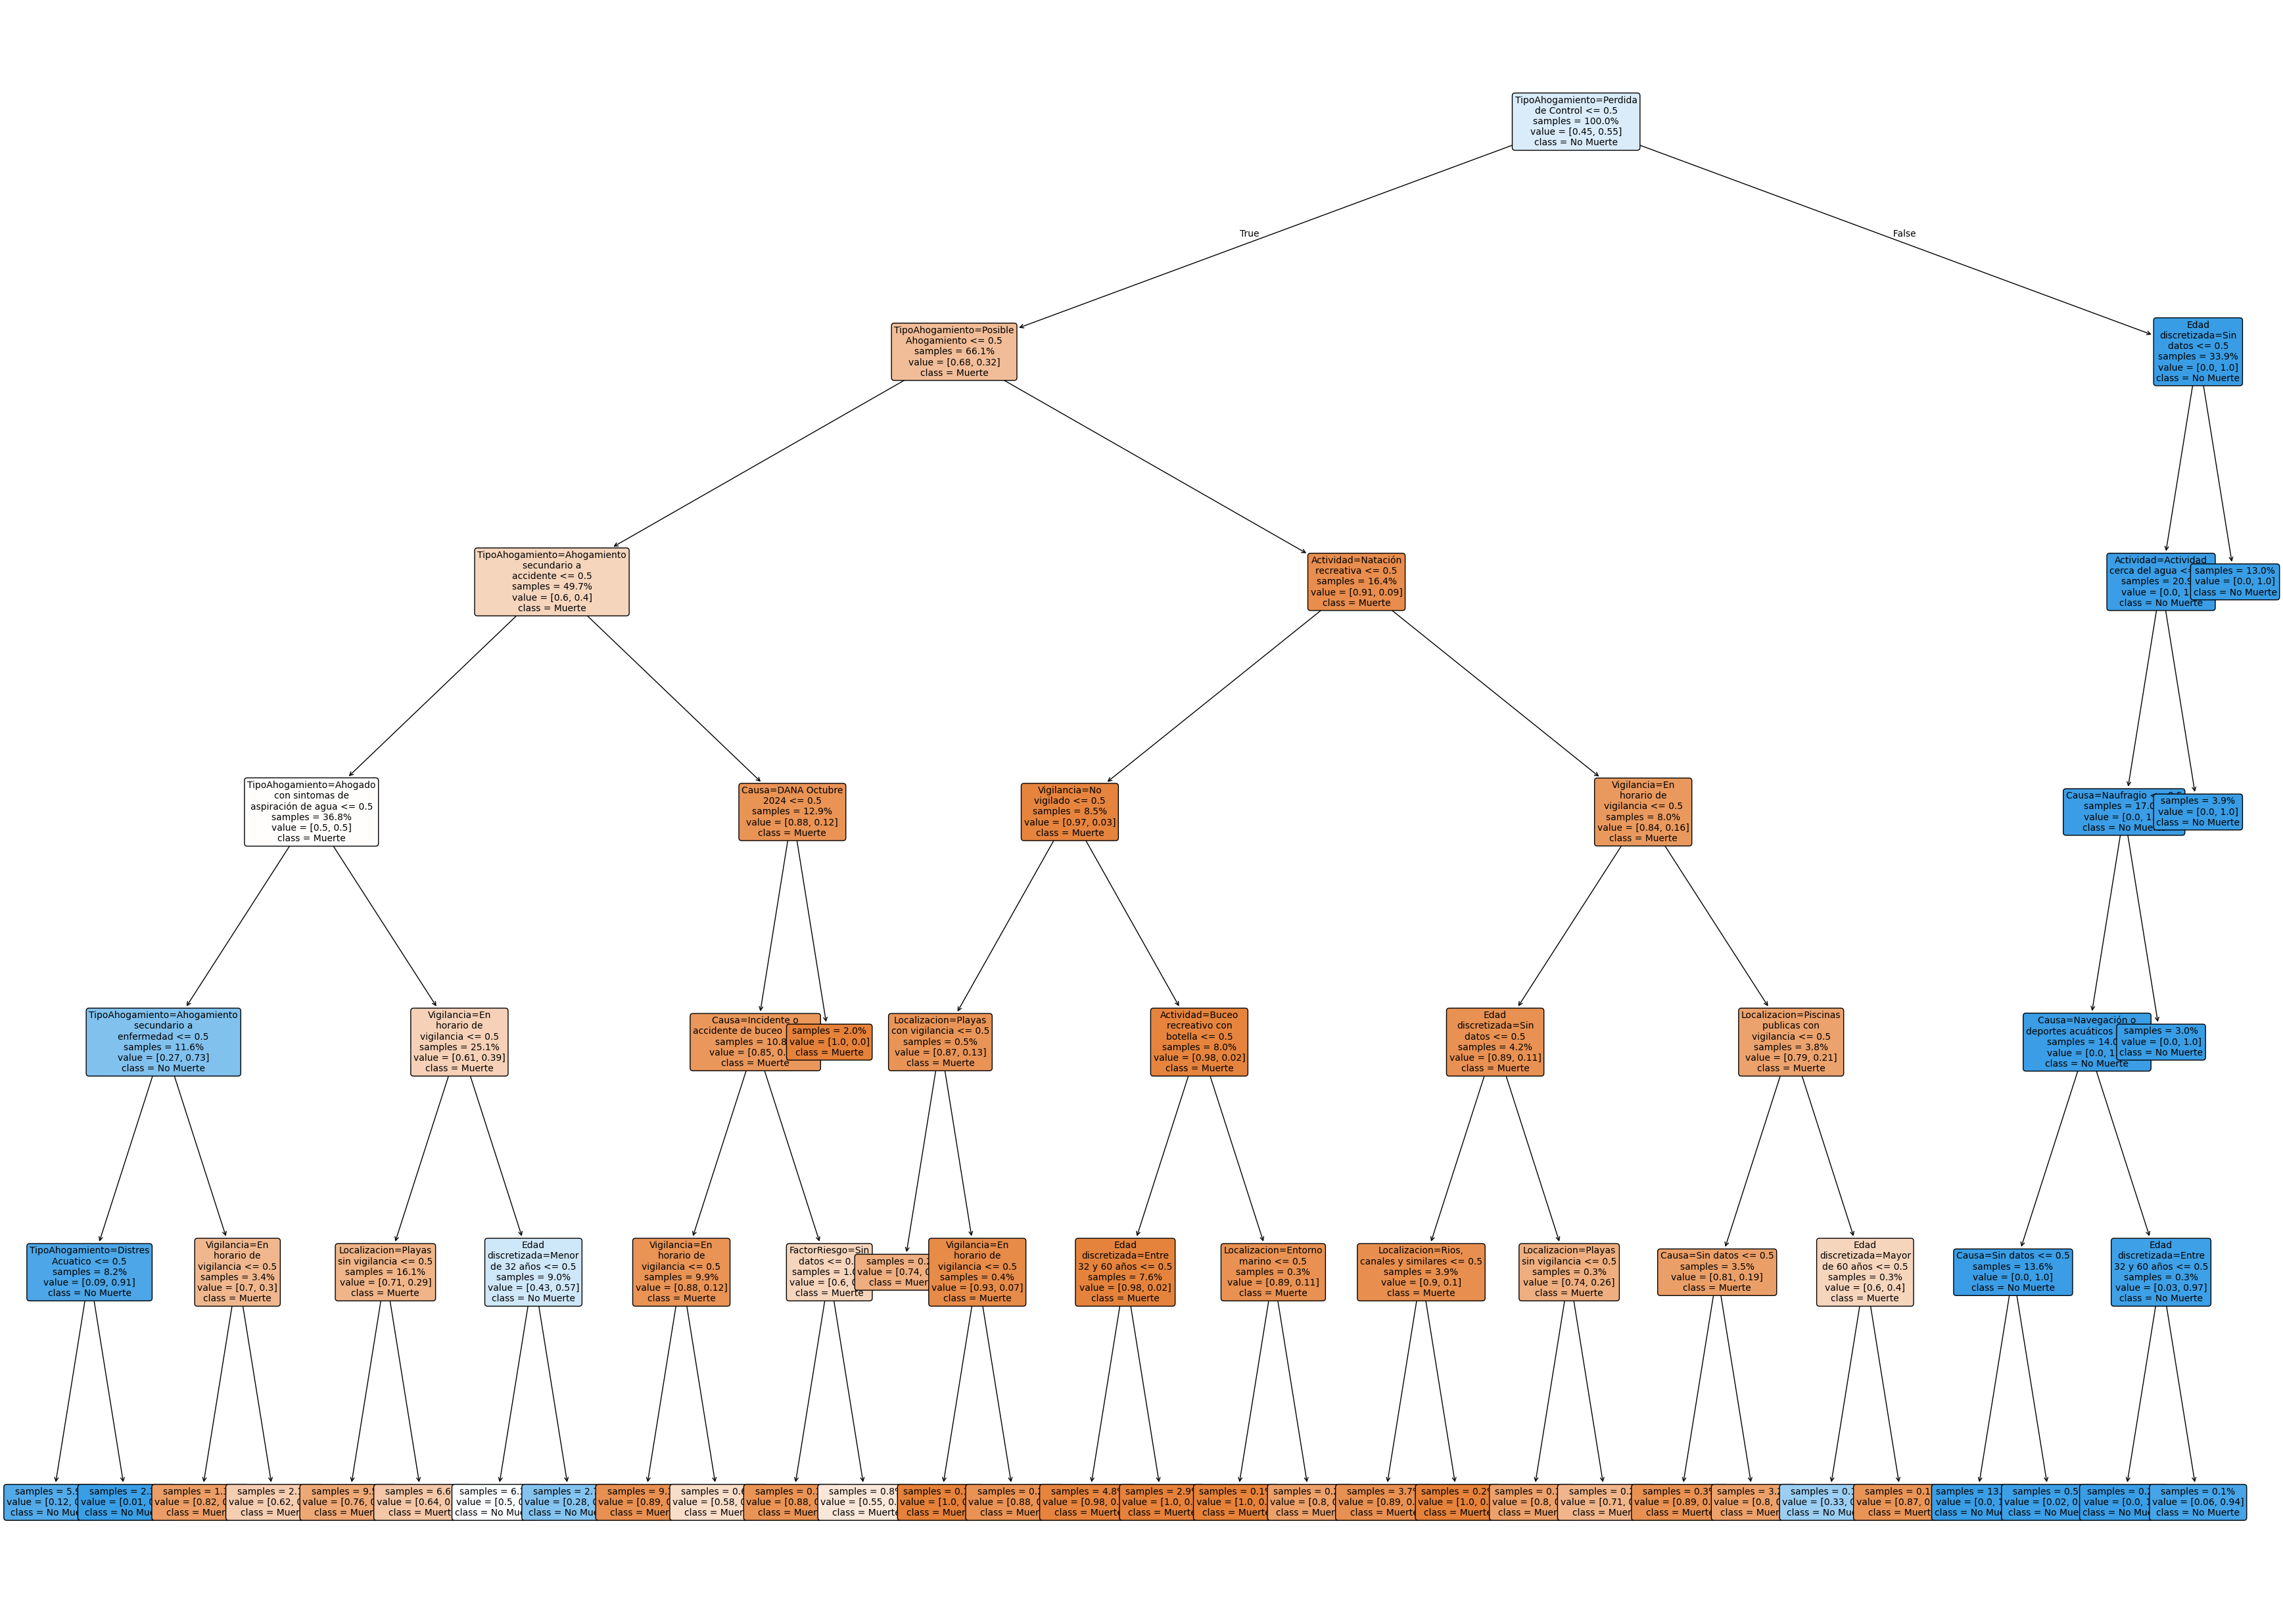

In [34]:

muerte = ['Ahogamiento mortal', 'Fallecimiento Sin Ahogamiento']
no_muerte = [
    'Rescate y traslado a supervisión médica',
    'Ahogamiento no mortal con hospitalizacion',
    'Rescate sin consecuencias',
    'Traumatismo/TRM',
    'Rescate con necesidad de observación posterior',
    'Lesiones'
]
cols = ['Edad_discretizada','FactorRiesgo', 'Localizacion', 'Causa', 'TipoAhogamiento','Vigilancia','Actividad']  
#cols = [  'CCAA', 'Vigilancia', 'Actividad', 'Deteccion', 'Intervencion', 'Localizacion','Riesgo', 'Sexo', 'Nacionalidad', 'Causa', 'FactorRiesgo', 'PrimerInterviniente', 'Extraccion', 'TipoAhogamiento' ,'Edad_discretizada']

data2 = data2.copy()
data2["Muerte"] = data2["Pronostico"].map(lambda x: "Muerte" if x in muerte else "No Muerte")

X = data2[cols]
y = data2["Muerte"]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="if_binary", sparse_output=False), cols)
    ]
)

clf = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=6,
    min_samples_leaf=10,
    random_state=42
)

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", clf)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y, cv=cv, scoring="accuracy")
print(f"Accuracy promedio (5-fold Stratified CV): {scores.mean():.3f}")

pipeline.fit(X, y)

clf_trained = pipeline.named_steps["classifier"]
feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()

def split_text(text, max_length=20):
    words = text.split(' ')
    lines = []
    current_line = ""
    
    for word in words:
        if len(current_line) + len(word) + 1 <= max_length:
            current_line += (" " if current_line else "") + word
        else:
            if current_line:
                lines.append(current_line)
            current_line = word
    
    if current_line:
        lines.append(current_line)
    
    return '\n'.join(lines)

def format_feature_names(feature_names):
    formatted_names = []
    for name in feature_names:
        if name.startswith('cat__'):
            clean_name = name.replace('cat__', '')
            
            if clean_name.startswith('Edad_discretizada_'):
                clean_name = clean_name.replace('Edad_discretizada_', 'Edad_discretizada=', 1)
            else:
                parts = clean_name.split('_', 1)
                clean_name = f"{parts[0]}={parts[1]}" if len(parts) > 1 else clean_name
            
            clean_name = clean_name.replace('_', ' ')
            
            clean_name = split_text(clean_name)
        else:
            clean_name = name
        
        formatted_names.append(clean_name)
    return formatted_names

feature_names_formatted = format_feature_names(feature_names)

tree_rules = export_text(clf_trained, feature_names=list(feature_names_formatted))


plt.figure(figsize=(11.69*3, 8.27*3))

plot_tree(
    clf_trained,
    feature_names=feature_names_formatted,
    class_names=clf_trained.classes_,
    filled=True,
    rounded=True,
    fontsize=10,  
    impurity=False,
    proportion=True,
    precision=2,
)

plt.tight_layout()

plt.savefig("arbol1_completo.png", bbox_inches="tight", dpi=150)
plt.show()

In [ ]:
muerte = ['Ahogamiento mortal', 'Fallecimiento Sin Ahogamiento']
no_muerte = [
    'Rescate y traslado a supervisión médica',
    'Ahogamiento no mortal con hospitalizacion',
    'Rescate sin consecuencias',
    'Traumatismo/TRM',
    'Rescate con necesidad de observación posterior',
    'Lesiones'
]
cols = ['Edad_discretizada','FactorRiesgo', 'Localizacion', 'Causa', 'TipoAhogamiento','Vigilancia','Actividad']  
#cols = [  'CCAA', 'Vigilancia', 'Actividad', 'Deteccion', 'Intervencion', 'Localizacion','Riesgo', 'Sexo', 'Nacionalidad', 'Causa', 'FactorRiesgo', 'PrimerInterviniente', 'Extraccion', 'TipoAhogamiento' ,'Edad_discretizada']

data2 = data2.copy()
data2["Muerte"] = data2["Pronostico"].map(lambda x: "Muerte" if x in muerte else "No Muerte")


muertes = data2[data2['Muerte'] == 'No Muerte']

muertes['Edad_discretizada'].value_counts(normalize=True) * 100


Edad_discretizada
Menor de 32 años      34.807935
Sin datos             30.273929
Entre 32 y 60 años    22.260705
Mayor de 60 años      12.657431
Name: proportion, dtype: float64

In [17]:
data2['Muerte'].value_counts(normalize=True) * 100 

Muerte
No Muerte    55.215577
Muerte       44.784423
Name: proportion, dtype: float64

In [18]:
data2[data2['Reanimacion'] == 'Sin Reanimacion']['Muerte'].value_counts(normalize=True) * 100

Muerte
No Muerte    97.819249
Muerte        2.180751
Name: proportion, dtype: float64

In [19]:
data2[data2['TipoAhogamiento'] == 'Perdida de Control']['Muerte'].value_counts(normalize=True) * 100

Muerte
No Muerte    99.820513
Muerte        0.179487
Name: proportion, dtype: float64

ARBOL OPTIMO CON PARAMETROS GRIDSEARCH,....

Mejores parámetros: {'classifier__criterion': 'entropy', 'classifier__max_depth': 9, 'classifier__min_samples_leaf': 5}
Mejor Accuracy (CV): 0.88
Reglas del árbol de decisión:
|--- Reanimacion=Sin
Reanimacion <= 0.50
|   |--- Reanimacion=Recuperacion
de cadaver <= 0.50
|   |   |--- TipoAhogamiento=Perdida
de Control <= 0.50
|   |   |   |--- TipoAhogamiento=Posible
Ahogamiento <= 0.50
|   |   |   |   |--- Reanimacion=SVA por
SEM <= 0.50
|   |   |   |   |   |--- Edad
discretizada=Menor
de 32 años <= 0.50
|   |   |   |   |   |   |--- Reanimacion=RCP
temprana por
transeuntes no
adiestrados <= 0.50
|   |   |   |   |   |   |   |--- Reanimacion=Sin
datos <= 0.50
|   |   |   |   |   |   |   |   |--- Edad
discretizada=Sin
datos <= 0.50
|   |   |   |   |   |   |   |   |   |--- class: Muerte
|   |   |   |   |   |   |   |   |--- Edad
discretizada=Sin
datos >  0.50
|   |   |   |   |   |   |   |   |   |--- class: No Muerte
|   |   |   |   |   |   |   |--- Reanimacion=Sin
datos >  0.50
|   |   |   | 

[Text(0.7251790364583334, 0.95, 'Reanimacion=Sin\nReanimacion <= 0.5\nsamples = 11504\nvalue = [5152, 6352]\nclass = No Muerte'),
 Text(0.5398763020833334, 0.85, 'Reanimacion=Recuperacion\nde cadaver <= 0.5\nsamples = 6735\nvalue = [5048.0, 1687.0]\nclass = Muerte'),
 Text(0.6325276692708334, 0.8999999999999999, 'True  '),
 Text(0.4860026041666667, 0.75, 'TipoAhogamiento=Perdida\nde Control <= 0.5\nsamples = 4204\nvalue = [2518, 1686]\nclass = Muerte'),
 Text(0.4095052083333333, 0.65, 'TipoAhogamiento=Posible\nAhogamiento <= 0.5\nsamples = 4001\nvalue = [2517, 1484]\nclass = Muerte'),
 Text(0.2877604166666667, 0.55, 'Reanimacion=SVA por\nSEM <= 0.5\nsamples = 3138\nvalue = [1813, 1325]\nclass = Muerte'),
 Text(0.1640625, 0.45, 'Edad\ndiscretizada=Menor\nde 32 años <= 0.5\nsamples = 2042\nvalue = [1059, 983]\nclass = Muerte'),
 Text(0.08333333333333333, 0.35, 'Reanimacion=RCP\ntemprana por\ntranseuntes no\nadiestrados <= 0.5\nsamples = 1478\nvalue = [852, 626]\nclass = Muerte'),
 Text(0

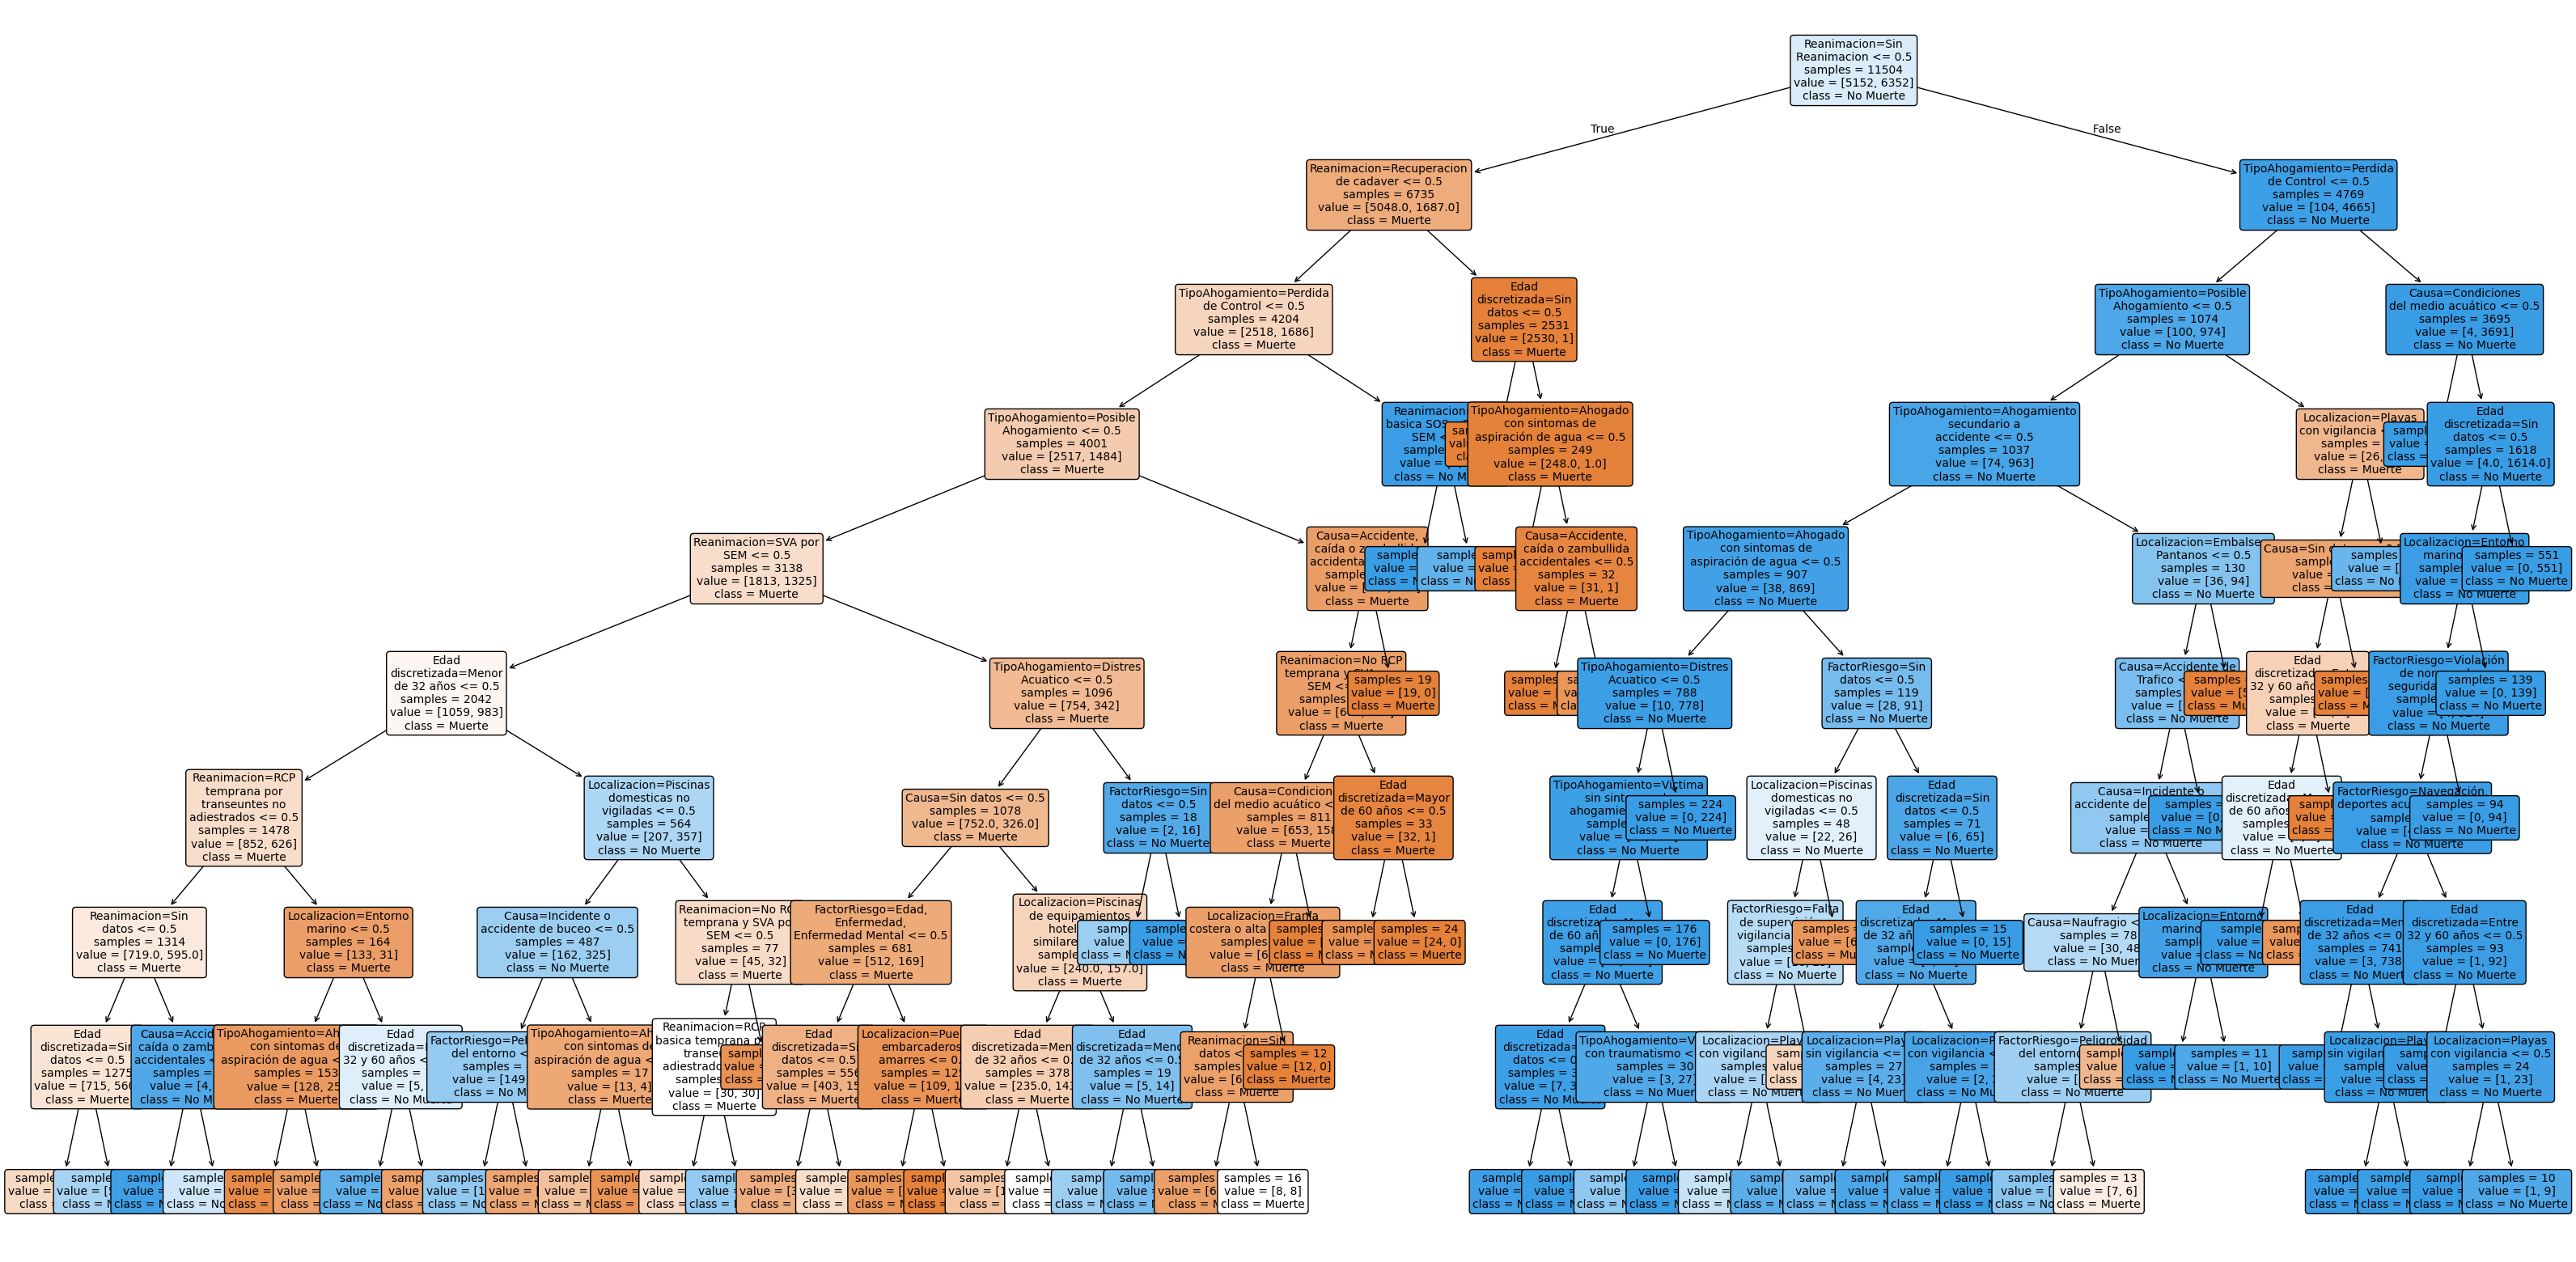

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

muerte = ['Ahogamiento mortal', 'Fallecimiento Sin Ahogamiento']
no_muerte = [
    'Rescate y traslado a supervisión médica',
    'Ahogamiento no mortal con hospitalizacion',
    'Rescate sin consecuencias',
    'Traumatismo/TRM',
    'Rescate con necesidad de observación posterior',
    'Lesiones'
]

cols = ['Edad_discretizada','FactorRiesgo', 'Localizacion', 'Causa', 'TipoAhogamiento', 'Reanimacion']

data2 = data2.copy()
data2["Muerte"] = data2["Pronostico"].map(lambda x: "Muerte" if x in muerte else "No Muerte")

X = data2[cols]
y = data2["Muerte"]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="if_binary", sparse_output=False), cols)
    ]
)

clf = DecisionTreeClassifier(random_state=42)

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", clf)
])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    "classifier__max_depth": [3, 5, 7, 9, None],
    "classifier__min_samples_leaf": [3, 5, 10, 20],
    "classifier__criterion": ["gini", "entropy"]
}

grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring="accuracy", n_jobs=-1)
grid.fit(X, y)

print("Mejores parámetros:", grid.best_params_)
print("Mejor Accuracy (CV):", round(grid.best_score_, 3))

best_model = grid.best_estimator_
best_model.fit(X, y)

clf_trained = best_model.named_steps["classifier"]
feature_names = best_model.named_steps["preprocessor"].get_feature_names_out()

def split_text(text, max_length=20):
    words = text.split(' ')
    lines = []
    current_line = ""
    for word in words:
        if len(current_line) + len(word) + 1 <= max_length:
            current_line += (" " if current_line else "") + word
        else:
            if current_line:
                lines.append(current_line)
            current_line = word
    if current_line:
        lines.append(current_line)
    return '\n'.join(lines)

def format_feature_names(feature_names):
    formatted_names = []
    for name in feature_names:
        if name.startswith('cat__'):
            clean_name = name.replace('cat__', '')
            if clean_name.startswith('Edad_discretizada_'):
                clean_name = clean_name.replace('Edad_discretizada_', 'Edad_discretizada=', 1)
            else:
                parts = clean_name.split('_', 1)
                clean_name = f"{parts[0]}={parts[1]}" if len(parts) > 1 else clean_name
            clean_name = clean_name.replace('_', ' ')
            clean_name = split_text(clean_name)
        else:
            clean_name = name
        formatted_names.append(clean_name)
    return formatted_names

feature_names_formatted = format_feature_names(feature_names)

tree_rules = export_text(clf_trained, feature_names=list(feature_names_formatted))
print("Reglas del árbol de decisión:")
print(tree_rules)

plt.figure(figsize=(40, 20))
plot_tree(
    clf_trained,
    feature_names=feature_names_formatted,
    class_names=clf_trained.classes_,
    filled=True,
    rounded=True,
    fontsize=10,
    impurity=False,
    proportion=False,
    precision=2,
)



METRICAS DE EVALUACION PARA EL MODELO DE ARRIBA
VER EL PORQUE PARA EXPLICARLO

In [31]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
hola = best_model.predict_proba(X_test)
print(best_model.classes_)

hola

['Muerte' 'No Muerte']


array([[0.32670455, 0.67329545],
       [0.        , 1.        ],
       [0.75628627, 0.24371373],
       ...,
       [0.5877095 , 0.4122905 ],
       [0.5877095 , 0.4122905 ],
       [0.        , 1.        ]])


Accuracy en test: 0.877


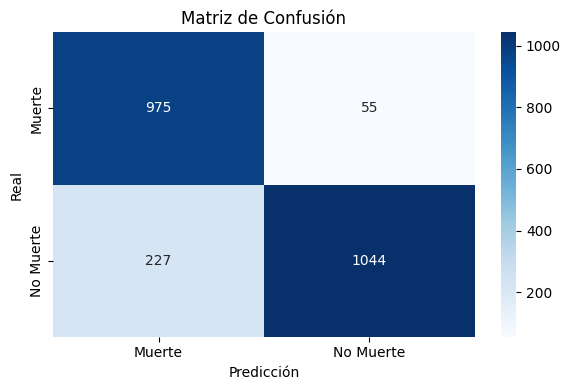


Reporte de Clasificación:
              precision    recall  f1-score   support

      Muerte       0.81      0.95      0.87      1030
   No Muerte       0.95      0.82      0.88      1271

    accuracy                           0.88      2301
   macro avg       0.88      0.88      0.88      2301
weighted avg       0.89      0.88      0.88      2301



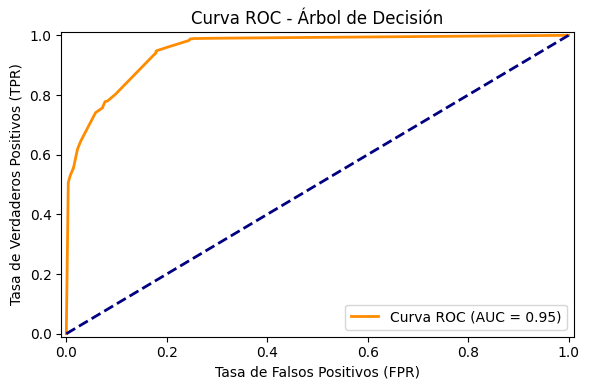

In [60]:

import seaborn as sns

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 0]  

acc = accuracy_score(y_test, y_pred)
print(f"\nAccuracy en test: {acc:.3f}")


cm = confusion_matrix(y_test, y_pred, labels=["Muerte", "No Muerte"])
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Muerte", "No Muerte"], yticklabels=["Muerte", "No Muerte"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.tight_layout()
plt.show()

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=["Muerte", "No Muerte"]))

fpr, tpr, thresholds = roc_curve(y_test.map(lambda x: 1 if x == "Muerte" else 0), y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"Curva ROC (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC - Árbol de Decisión")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()




RANDOM FOREST


🔍 Mejores parámetros encontrados: {'classifier__max_depth': 15, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 100}
✅ Mejor Accuracy promedio (CV): 0.889


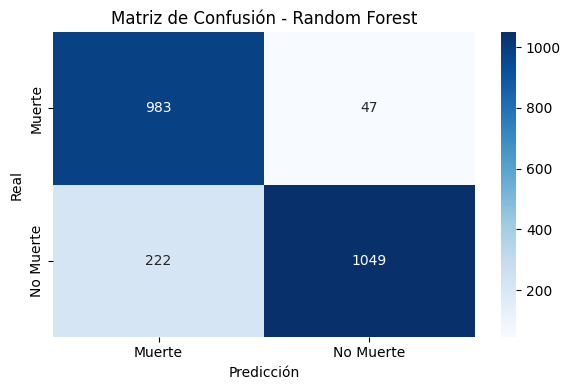


📊 Reporte de Clasificación:
              precision    recall  f1-score   support

      Muerte       0.82      0.95      0.88      1030
   No Muerte       0.96      0.83      0.89      1271

    accuracy                           0.88      2301
   macro avg       0.89      0.89      0.88      2301
weighted avg       0.89      0.88      0.88      2301



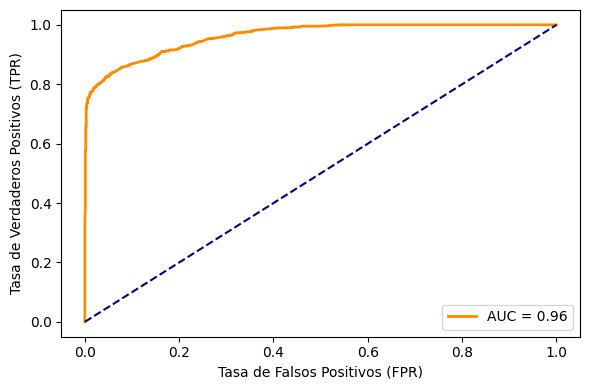

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)

muerte = ['Ahogamiento mortal', 'Fallecimiento Sin Ahogamiento']
no_muerte = [
    'Rescate y traslado a supervisión médica',
    'Ahogamiento no mortal con hospitalizacion',
    'Rescate sin consecuencias',
    'Traumatismo/TRM',
    'Rescate con necesidad de observación posterior',
    'Lesiones'
]

cols = ['Edad_discretizada','FactorRiesgo', 'Localizacion', 'Causa', 'TipoAhogamiento', 'Reanimacion']

data2 = data2.copy()
data2["Muerte"] = data2["Pronostico"].map(lambda x: "Muerte" if x in muerte else "No Muerte")

X = data2[cols]
y = data2["Muerte"]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="if_binary", sparse_output=False), cols)
    ]
)
clf = RandomForestClassifier(random_state=42)

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", clf)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    "classifier__n_estimators": [50, 100, 150],
    "classifier__max_depth": [ 10, 15, 20,None],
    "classifier__min_samples_leaf": [2, 5],
    "classifier__max_features": ["sqrt", "log2"]
}

grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring="accuracy", n_jobs=-1)
grid.fit(X, y)

print("🔍 Mejores parámetros encontrados:", grid.best_params_)
print("✅ Mejor Accuracy promedio (CV):", round(grid.best_score_, 3))

best_model = grid.best_estimator_

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1] 

cm = confusion_matrix(y_test, y_pred, labels=["Muerte", "No Muerte"])
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Muerte", "No Muerte"], 
            yticklabels=["Muerte", "No Muerte"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Random Forest")
plt.tight_layout()
plt.show()

print("\n📊 Reporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=["Muerte", "No Muerte"]))

fpr, tpr, thresholds = roc_curve(
    y_test.map(lambda x: 1 if x == "No Muerte" else 0), y_proba
)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("curva_roc_rf.png", dpi=150)
plt.show()



🌟 Variables más importantes (top 15):
                                  Variable codificada  Importancia
78                        Reanimacion_Sin Reanimacion     0.275806
75                Reanimacion_Recuperacion de cadaver     0.172621
63                 TipoAhogamiento_Perdida de Control     0.130241
64                TipoAhogamiento_Posible Ahogamiento     0.056080
59  TipoAhogamiento_Ahogamiento secundario a accid...     0.045601
39               Causa_Condiciones del medio acuático     0.036409
56  TipoAhogamiento_Ahogado con sintomas de aspira...     0.032267
53                                    Causa_Sin datos     0.030988
76                            Reanimacion_SVA por SEM     0.024541
1                  Edad_discretizada_Mayor de 60 años     0.017666
70           Reanimacion_RCP basica SOS y SVA por SEM     0.015270
3                         Edad_discretizada_Sin datos     0.014281
79                              Reanimacion_Sin datos     0.013352
2                  Edad

C:\Users\Pablo\AppData\Local\Temp\ipykernel_2456\2535538229.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


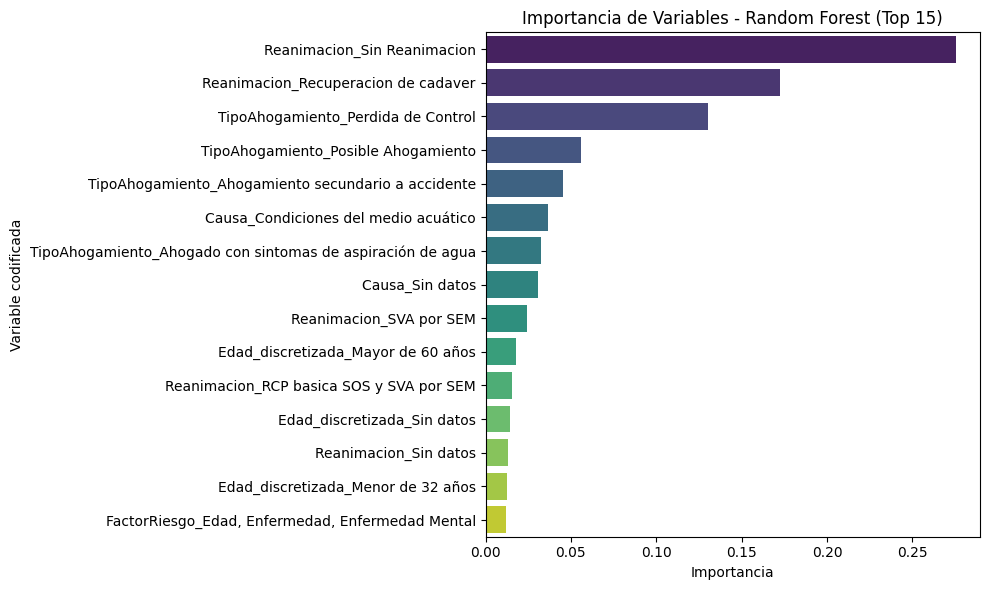

In [10]:
import numpy as np

rf_model = best_model.named_steps["classifier"]
ohe = best_model.named_steps["preprocessor"].named_transformers_["cat"]

feature_names = ohe.get_feature_names_out(cols)

importances = rf_model.feature_importances_

importance_df = pd.DataFrame({
    "Variable codificada": feature_names,
    "Importancia": importances
}).sort_values(by="Importancia", ascending=False)

print("\n🌟 Variables más importantes (top 15):")
print(importance_df.head(15))

plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importancia",
    y="Variable codificada",
    data=importance_df.head(15),
    palette="viridis"
)
plt.title("Importancia de Variables - Random Forest (Top 15)")
plt.xlabel("Importancia")
plt.ylabel("Variable codificada")
plt.tight_layout()
plt.show()


REGRESION LOGISTICA

Mejores parámetros: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Mejor Accuracy (CV): 0.887

Accuracy en test: 0.876


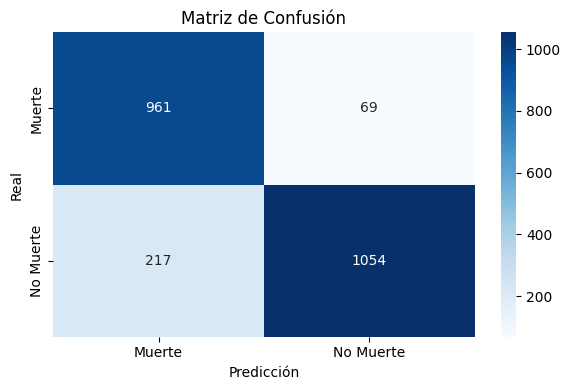


Reporte de Clasificación:
              precision    recall  f1-score   support

      Muerte       0.82      0.93      0.87      1030
   No Muerte       0.94      0.83      0.88      1271

    accuracy                           0.88      2301
   macro avg       0.88      0.88      0.88      2301
weighted avg       0.88      0.88      0.88      2301



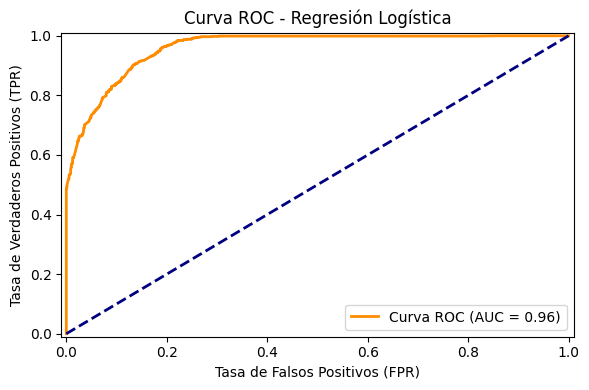

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc, accuracy_score
)

muerte = ['Ahogamiento mortal', 'Fallecimiento Sin Ahogamiento']
no_muerte = [
    'Rescate y traslado a supervisión médica',
    'Ahogamiento no mortal con hospitalizacion',
    'Rescate sin consecuencias',
    'Traumatismo/TRM',
    'Rescate con necesidad de observación posterior',
    'Lesiones'
]

cols = ['Edad_discretizada','FactorRiesgo', 'Localizacion', 'Causa', 'TipoAhogamiento', 'Reanimacion']

data2 = data2.copy()
data2["Muerte"] = data2["Pronostico"].map(lambda x: "Muerte" if x in muerte else "No Muerte")

X = data2[cols]
y = data2["Muerte"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="if_binary", sparse_output=False), cols)
    ]
)

clf = LogisticRegression(random_state=42, max_iter=1000)

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", clf)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    "classifier__C": [0.01, 0.1, 1, 10, 100],      
    "classifier__penalty": ["l2"],               
    "classifier__solver": ["lbfgs"]                 
}

grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring="accuracy", n_jobs=-1)
grid.fit(X_train, y_train)

print("Mejores parámetros:", grid.best_params_)
print("Mejor Accuracy (CV):", round(grid.best_score_, 3))

best_model = grid.best_estimator_
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 0]  

# 10. Métricas de evaluación

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"\nAccuracy en test: {acc:.3f}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.tight_layout()
plt.show()

# Reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=best_model.classes_))

# Curva ROC
y_test_bin = y_test.map(lambda x: 1 if x == "Muerte" else 0)
fpr, tpr, thresholds = roc_curve(y_test_bin, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"Curva ROC (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC - Regresión Logística")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("curva_roc_rl.png", dpi=150)
plt.show()


parecdio a random forest en resultados

In [7]:

feature_names = best_model.named_steps["preprocessor"].get_feature_names_out()
feature_names = [name.replace("cat_", "").lstrip("_") for name in feature_names]

coef = best_model.named_steps["classifier"].coef_[0] 

import pandas as pd
from numpy import exp

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coef
})

coef_df["abs_coef"] = coef_df["coefficient"].abs()
coef_df = coef_df.sort_values(by="abs_coef", ascending=False)


exponenciales = exp(coef_df["coefficient"])
coef_df["exponential"] = exp(coef_df["coefficient"])


Clase positiva es no muerte es es la del indice [0,1] el 1 ES DECIR LA SEGUNDA

In [8]:
best_model.classes_[1]


'No Muerte'

                                              feature  exponential
75                Reanimacion_Recuperacion de cadaver     0.043261
63                 TipoAhogamiento_Perdida de Control     9.466840
78                        Reanimacion_Sin Reanimacion     8.669430
64                TipoAhogamiento_Posible Ahogamiento     0.180003
59  TipoAhogamiento_Ahogamiento secundario a accid...     0.328766
61                   TipoAhogamiento_Distres Acuatico     2.685889
79                              Reanimacion_Sin datos     2.586255
25  Localizacion_Piscinas de equipamientos hoteler...     2.073137
67  TipoAhogamiento_Victima sin sintomas de ahogam...     1.757766
66            TipoAhogamiento_Victima con traumatismo     1.695784
26  Localizacion_Piscinas de urbanizaciones con vi...     1.632076
72  Reanimacion_RCP basica por socorrista en servicio     1.577773
3                         Edad_discretizada_Sin datos     1.521244
73  Reanimacion_RCP basica temprana por transeunte...     1.50

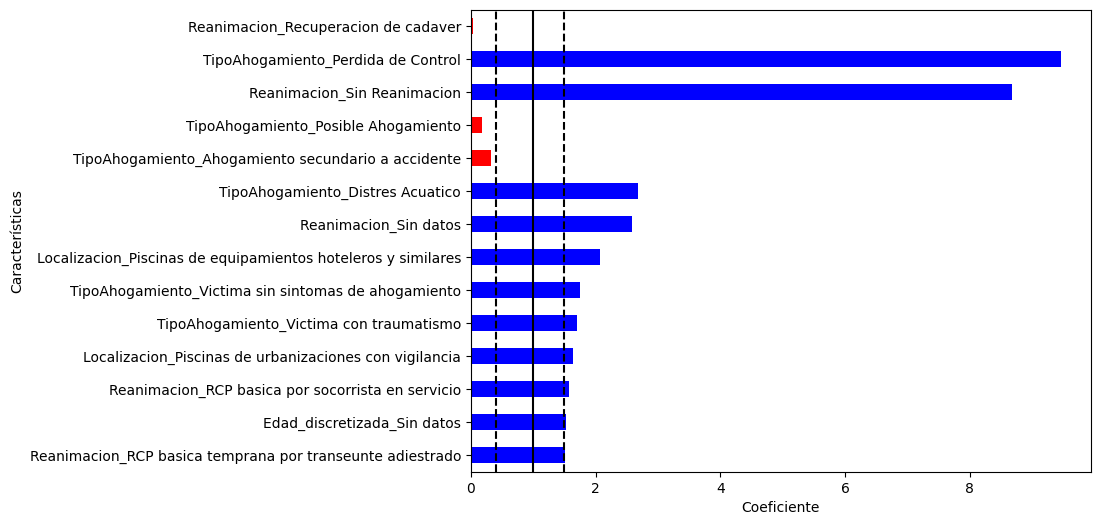

In [35]:

coef_df_filtered = coef_df[(coef_df["exponential"] < 0.4) | (coef_df["exponential"] > 1.5)]
print(coef_df_filtered[['feature', 'exponential']])

plt.figure(figsize=(8, 6))

coef_df_filtered.plot.barh(
    x="feature",
    y="exponential",
    color=coef_df_filtered["exponential"].apply(lambda x: "red" if x < 1 else "blue"),
    legend=False,
    ax=plt.gca()
)

plt.xlabel("Coeficiente")
plt.ylabel("Características")
plt.gca().invert_yaxis()

plt.axvline(x=1, color='black', linestyle='-')        
plt.axvline(x=0.4, color='black', linestyle='--')       
plt.axvline(x=1.5, color='black', linestyle='--')    
plt.savefig('coeficientes rlogistica.png',dpi=150, bbox_inches='tight')
plt.show()



Tenemos un problema muy gordo con las variables categoricas ya que no nos dejan aplicar arboles de clasificacion de una manera correcta

In [33]:
import pandas as pd

tipos_interes = [
    'Ahogado con sintomas de aspiración de agua',
    'Ahogamiento secundario a accidente',
    'Ahogamiento secundario a enfermedad',
    'Posible Ahogamiento',
    'Perdida de Control'
]

df_filtrado = data2[data2['TipoAhogamiento'].isin(tipos_interes)]

porcentajes = (
    df_filtrado.groupby('Muerte')['TipoAhogamiento']
    .value_counts(normalize=True)
    .mul(100)
    .rename('Porcentaje')
    .reset_index()
)
print(porcentajes)


       Muerte                             TipoAhogamiento  Porcentaje
0      Muerte  Ahogado con sintomas de aspiración de agua   34.871795
1      Muerte                         Posible Ahogamiento   33.964497
2      Muerte          Ahogamiento secundario a accidente   25.601578
3      Muerte         Ahogamiento secundario a enfermedad    5.424063
4      Muerte                          Perdida de Control    0.138067
5      Muerte                     Ahogado por hidrocucion    0.000000
6      Muerte  Ahogado sin sintomas de aspiración de agua    0.000000
7      Muerte                            Distres Acuatico    0.000000
8      Muerte                   Muerte previa a inmersion    0.000000
9      Muerte                                   Sin datos    0.000000
10     Muerte                     Victima con traumatismo    0.000000
11     Muerte         Victima sin sintomas de ahogamiento    0.000000
12  No Muerte                          Perdida de Control   70.923666
13  No Muerte  Ahoga

In [113]:
data2['TipoAhogamiento'].value_counts()

TipoAhogamiento
Perdida de Control                            3900
Ahogado con sintomas de aspiración de agua    2891
Posible Ahogamiento                           1892
Ahogamiento secundario a accidente            1483
Ahogamiento secundario a enfermedad            393
Victima con traumatismo                        370
Distres Acuatico                               267
Victima sin sintomas de ahogamiento            186
Ahogado sin sintomas de aspiración de agua      53
Sin datos                                       32
Muerte previa a inmersion                       20
Ahogado por hidrocucion                         17
Name: count, dtype: int64

In [56]:
data2[data2['TipoAhogamiento'] == 'Perdida de Control'].groupby('Muerte').size()

Muerte
Muerte          7
No Muerte    3893
dtype: int64

Es importante decidir que es lo que queremos observar es decir la variable objetivo

Edad, Mortandad que esta en la columna Pronostico

OBJETIVO ES EDAD_DISCRETIZADA

Accuracy promedio (5-fold Stratified CV): 0.701
|--- FactorRiesgo=Edad,
Enfermedad,
Enfermedad Mental <= 0.50
|   |--- Pronostico=Ahogamiento
mortal <= 0.50
|   |   |--- FactorRiesgo=Falta
de supervisión o
vigilancia <= 0.50
|   |   |   |--- Causa=Condiciones
del medio acuático <= 0.50
|   |   |   |   |--- Causa=Falta de
supervisión o
vigilancia <= 0.50
|   |   |   |   |   |--- class: Menor de 32 años
|   |   |   |   |--- Causa=Falta de
supervisión o
vigilancia >  0.50
|   |   |   |   |   |--- class: Menor de 32 años
|   |   |   |--- Causa=Condiciones
del medio acuático >  0.50
|   |   |   |   |--- Pronostico=Rescate
sin consecuencias <= 0.50
|   |   |   |   |   |--- class: Menor de 32 años
|   |   |   |   |--- Pronostico=Rescate
sin consecuencias >  0.50
|   |   |   |   |   |--- class: Menor de 32 años
|   |   |--- FactorRiesgo=Falta
de supervisión o
vigilancia >  0.50
|   |   |   |--- Localizacion=Playas
sin vigilancia <= 0.50
|   |   |   |   |--- class: Menor de 32 años
|   |   |   

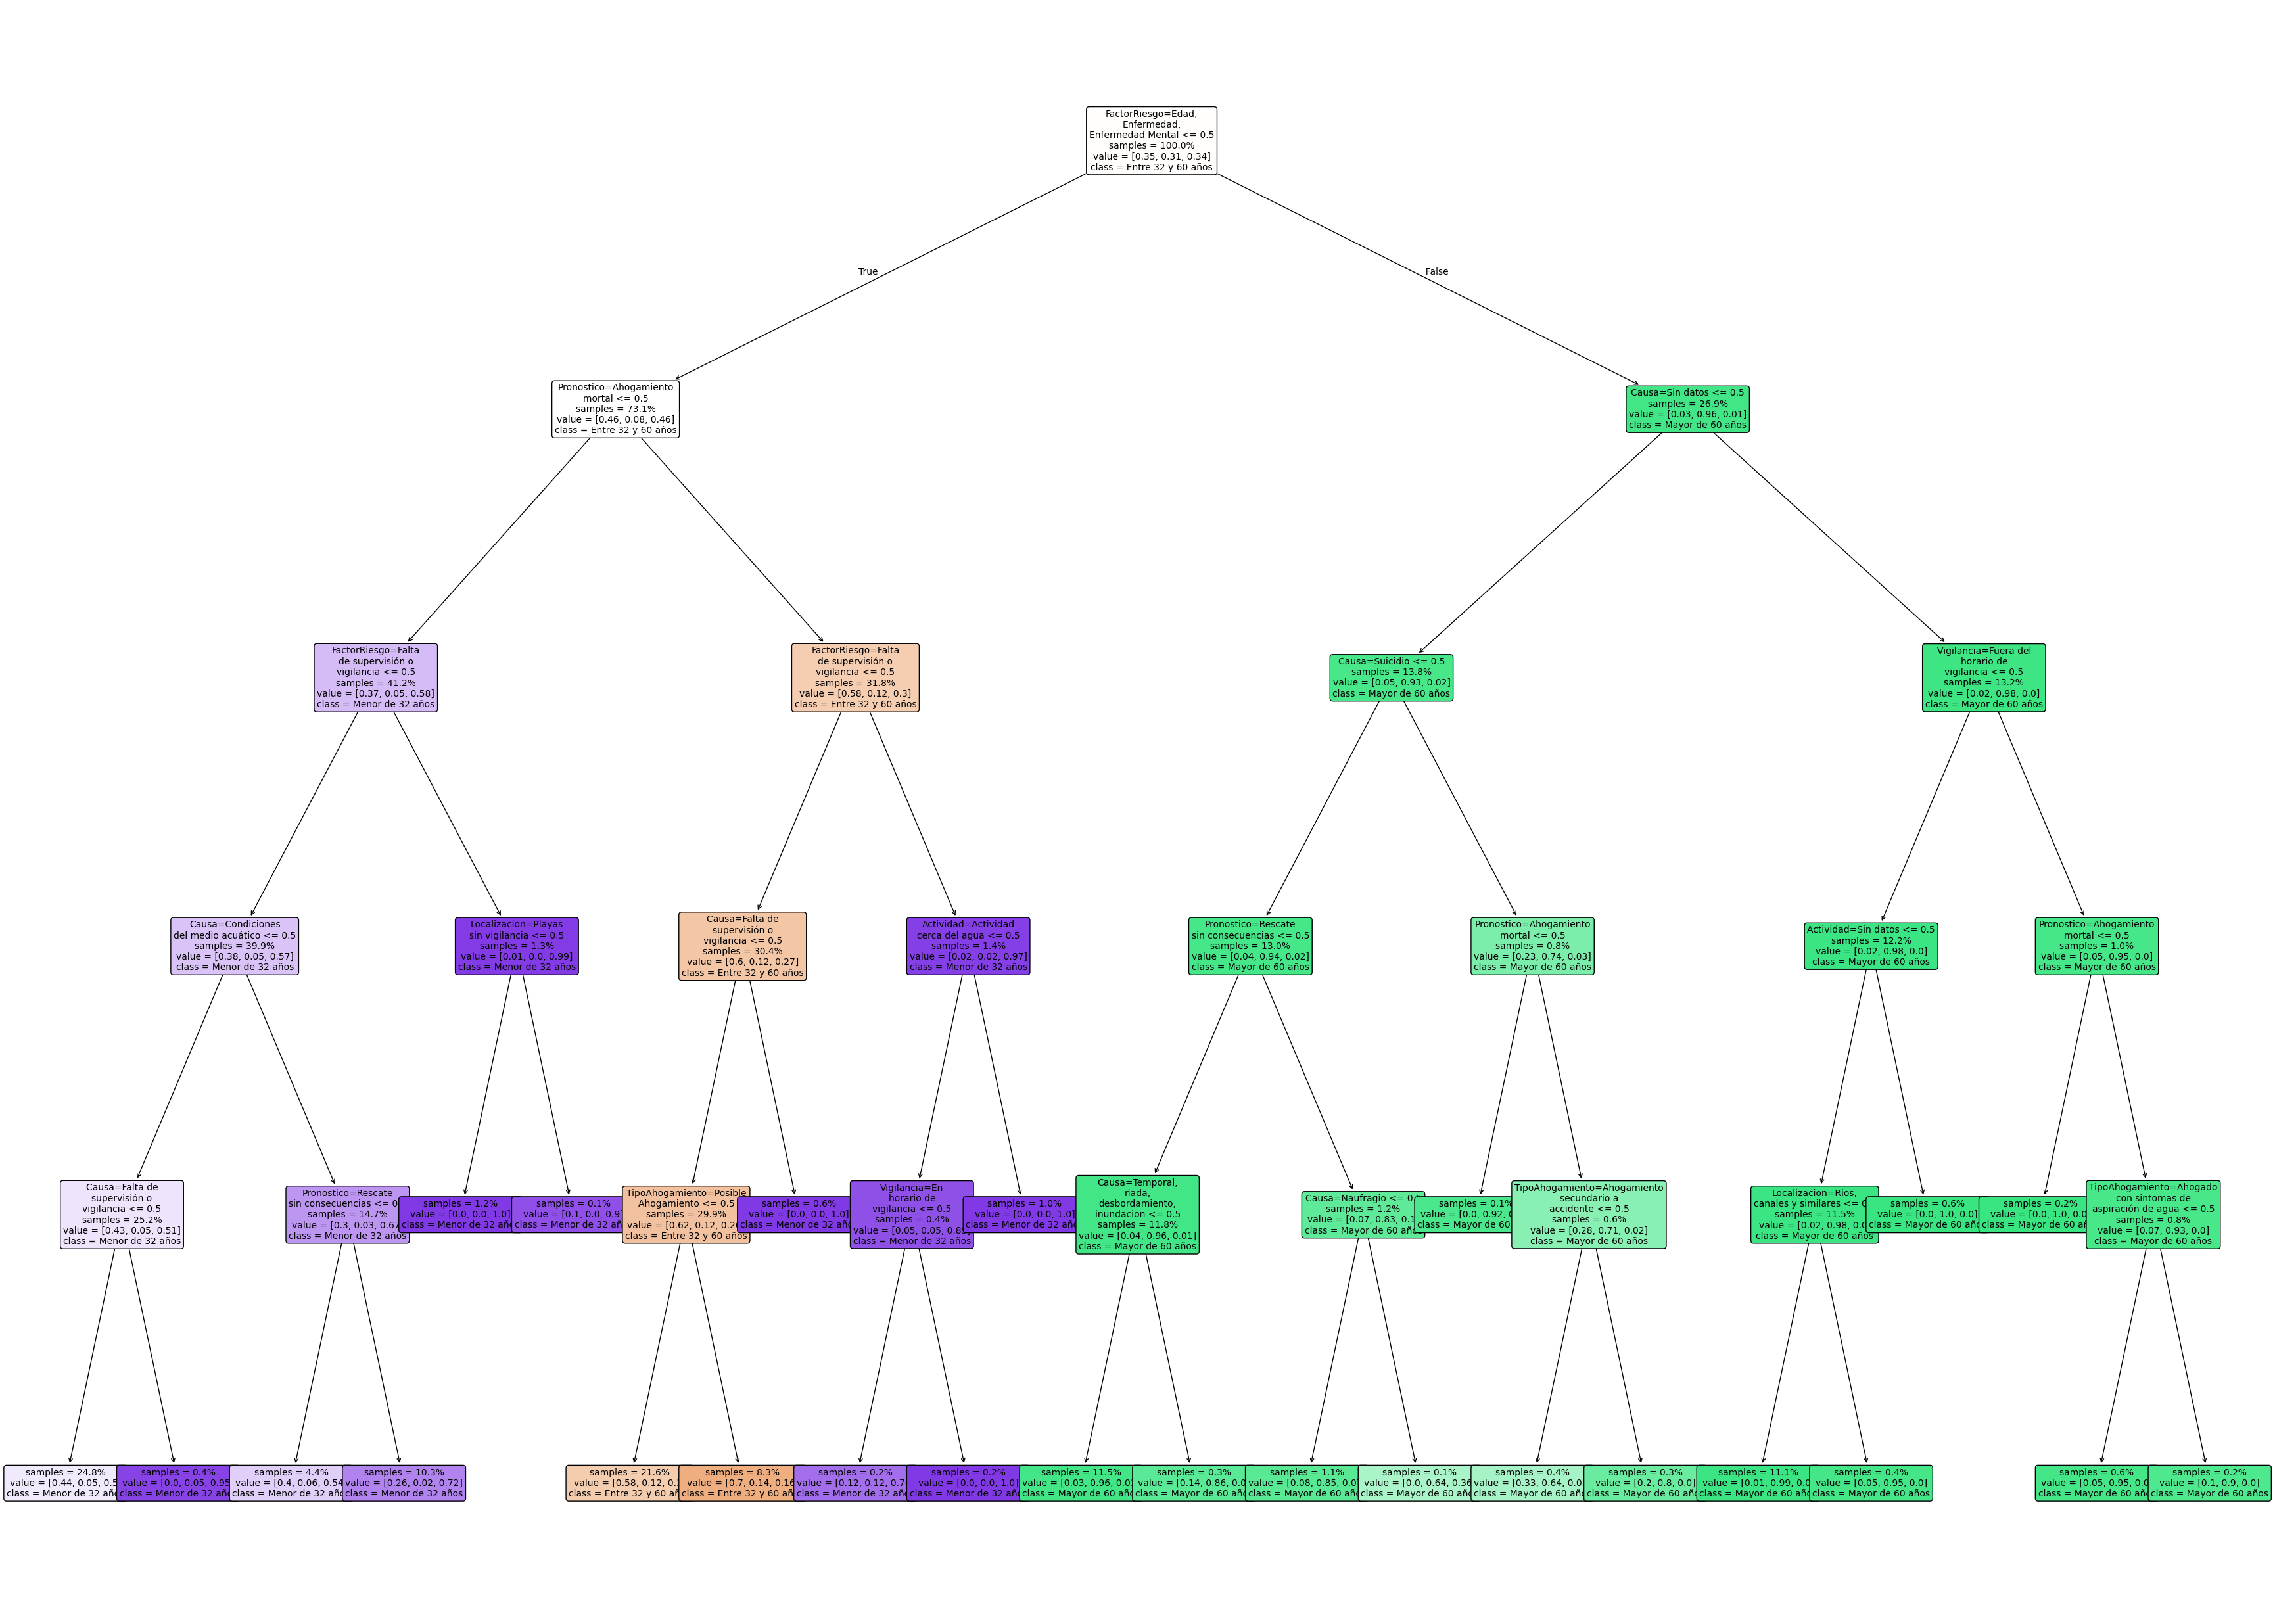

In [42]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import StratifiedKFold, cross_val_score
import matplotlib.pyplot as plt
import pandas as pd

cols = ['FactorRiesgo', 'Localizacion', 'Causa', 'TipoAhogamiento', 'Vigilancia', 'Actividad', 'Pronostico']

orden_clases = ["Menor de 32 años", "Entre 32 y 60 años", "Mayor de 60 años"]
data_filtrada = data2[data2["Edad_discretizada"].isin(orden_clases)].copy()

data_filtrada["Edad_discretizada"] = pd.Categorical(
    data_filtrada["Edad_discretizada"],
    categories=orden_clases,
    ordered=True
)

X = data_filtrada[cols]

y = data_filtrada["Edad_discretizada"].astype(str)

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="if_binary", sparse_output=False), cols)
    ]
)

clf = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=5,
    min_samples_leaf=10,
    random_state=42
)

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", clf)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y, cv=cv, scoring="accuracy")
print(f"Accuracy promedio (5-fold Stratified CV): {scores.mean():.3f}")

pipeline.fit(X, y)
clf_trained = pipeline.named_steps["classifier"]

feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()

def split_text(text, max_length=20):
    words = text.split(' ')
    lines = []
    current_line = ""
    for word in words:
        if len(current_line) + len(word) + 1 <= max_length:
            current_line += (" " if current_line else "") + word
        else:
            if current_line:
                lines.append(current_line)
            current_line = word
    if current_line:
        lines.append(current_line)
    return '\n'.join(lines)

def format_feature_names(feature_names):
    formatted_names = []
    for name in feature_names:
        if name.startswith('cat__'):
            clean_name = name.replace('cat__', '')
            parts = clean_name.split('_', 1)
            clean_name = f"{parts[0]}={parts[1]}" if len(parts) > 1 else clean_name
            clean_name = clean_name.replace('_', ' ')
            clean_name = split_text(clean_name)
        else:
            clean_name = name
        formatted_names.append(clean_name)
    return formatted_names

feature_names_formatted = format_feature_names(feature_names)

tree_rules = export_text(clf_trained, feature_names=list(feature_names_formatted))
print(tree_rules)

orden_deseado = ["Menor de 32 años", "Entre 32 y 60 años", "Mayor de 60 años"]
mapa_clases = {nombre: nombre for nombre in orden_deseado}
clases_modelo = list(clf_trained.classes_)
class_names_reordenadas = [mapa_clases[c] for c in clases_modelo]

plt.figure(figsize=(11.69*3, 8.27*3))
plot_tree(
    clf_trained,
    feature_names=feature_names_formatted,
    class_names=class_names_reordenadas,
    filled=True,
    rounded=True,
    fontsize=10,
    impurity=False,
    proportion=True,
    precision=2,
)
plt.tight_layout()
plt.savefig("arbol_EDAD_completo.png", bbox_inches="tight", dpi=150)
plt.show()


In [43]:

rules_entre_32_60 = [rule for rule in tree_rules.splitlines() if "class: Entre 32 y 60 años" in rule]

for rule in rules_entre_32_60:
    print(rule)

|   |   |   |   |   |--- class: Entre 32 y 60 años
|   |   |   |   |   |--- class: Entre 32 y 60 años


C:\Users\Pablo\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Mejores parámetros: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Mejor Accuracy (CV): 0.715


C:\Users\Pablo\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


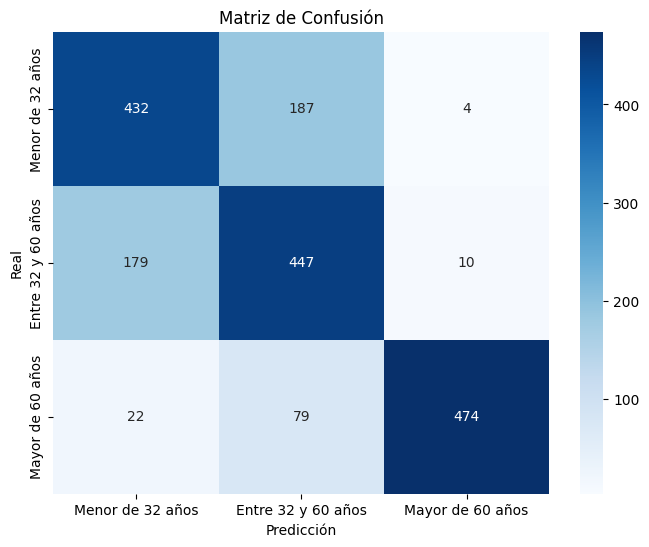


Reporte de Clasificación (2 decimales):
                    precision    recall  f1-score   support

  Menor de 32 años       0.68      0.69      0.69       623
Entre 32 y 60 años       0.63      0.70      0.66       636
  Mayor de 60 años       0.97      0.82      0.89       575

          accuracy                           0.74      1834
         macro avg       0.76      0.74      0.75      1834
      weighted avg       0.75      0.74      0.74      1834



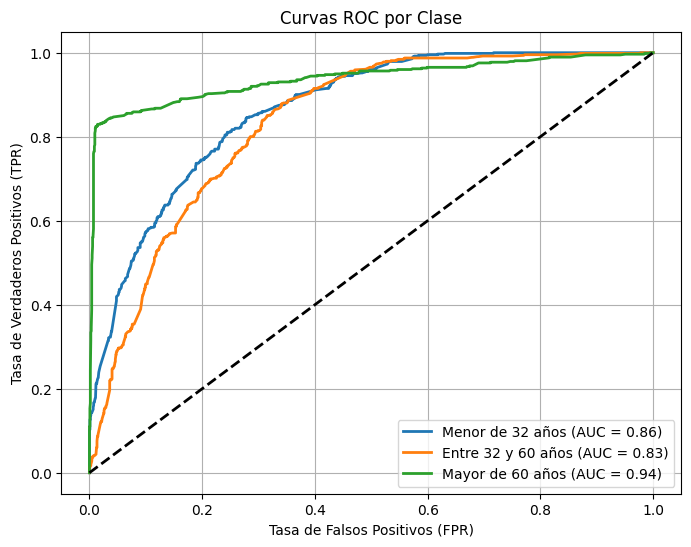

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

orden_clases = ["Menor de 32 años", "Entre 32 y 60 años", "Mayor de 60 años"]

data2["Edad_discretizada"] = pd.Categorical(
    data2["Edad_discretizada"], 
    categories=orden_clases,
    ordered=True
)

cols = ['FactorRiesgo', 'Localizacion', 'Causa', 'TipoAhogamiento', 'Reanimacion']
X = data2[cols]
y = data2["Edad_discretizada"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

preprocessor = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(drop="if_binary", sparse_output=False), cols)]
)

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(random_state=42, max_iter=1000, multi_class="multinomial"))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    "classifier__C": [0.01, 0.1, 1, 10, 100],
    "classifier__penalty": ["l2"],
    "classifier__solver": ["lbfgs", "sag", "saga"]
}

grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring="accuracy", n_jobs=-1)
grid.fit(X_train, y_train)

print("Mejores parámetros:", grid.best_params_)
print("Mejor Accuracy (CV):", round(grid.best_score_, 3))

best_model = grid.best_estimator_
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=orden_clases)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=orden_clases,
    yticklabels=orden_clases
)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

print("\nReporte de Clasificación (2 decimales):")
report = classification_report(
    y_test, y_pred,
    labels=orden_clases,
    target_names=orden_clases,
    digits=2,
    output_dict=False
)
print(report)

y_proba = best_model.predict_proba(X_test)
clases_modelo = best_model.classes_

plt.figure(figsize=(8, 6))

for i, clase in enumerate(orden_clases):
    if clase not in clases_modelo:
        continue
    idx = list(clases_modelo).index(clase)
    y_test_bin = (y_test == clase).astype(int)
    y_score = y_proba[:, idx]
    fpr, tpr, _ = roc_curve(y_test_bin, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{clase} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curvas ROC por Clase")
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('curva_roc_rl_edad.png', dpi=150, bbox_inches='tight')
plt.show()


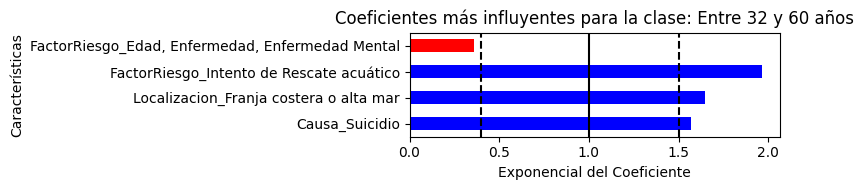

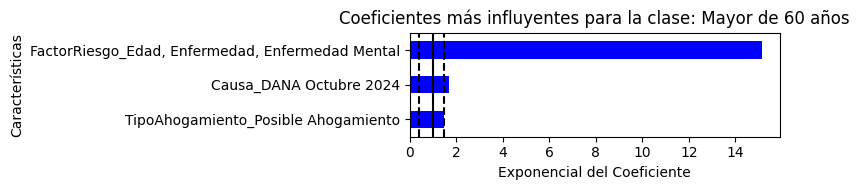

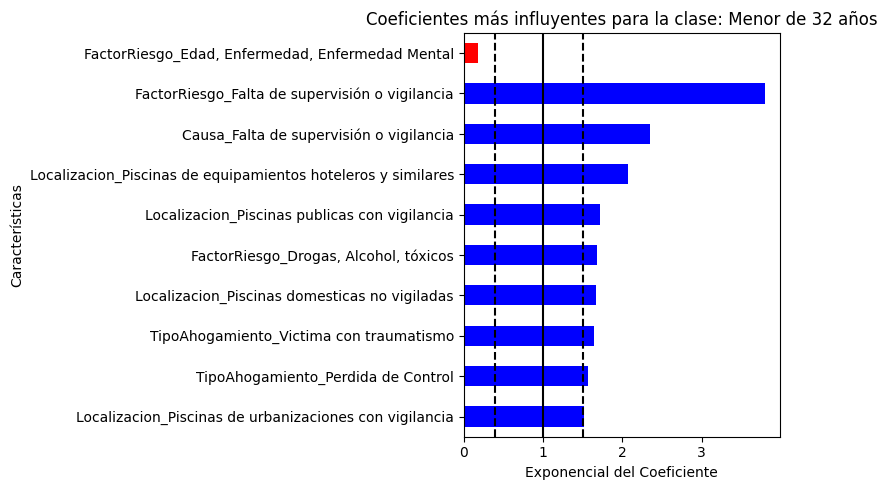

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
from numpy import exp

feature_names = best_model.named_steps["preprocessor"].get_feature_names_out()
feature_names = [name.replace("cat_", "").lstrip("_") for name in feature_names]

coef_matrix = best_model.named_steps["classifier"].coef_
clases = best_model.named_steps["classifier"].classes_

coef_dfs = []

for i, clase in enumerate(clases):
    coef = coef_matrix[i]
    coef_df = pd.DataFrame({
        "feature": feature_names,
        "coefficient": coef,
        "class": clase
    })
    coef_df["abs_coef"] = coef_df["coefficient"].abs()
    coef_df["exponential"] = exp(coef_df["coefficient"])
    coef_df_filtered = coef_df[(coef_df["exponential"] < 0.4) | (coef_df["exponential"] > 1.5)]
    coef_df_filtered = coef_df_filtered.sort_values(by="abs_coef", ascending=False)
    coef_dfs.append(coef_df_filtered)

    num_features = len(coef_df_filtered)
    height = max(2, num_features * 0.5)

    plt.figure(figsize=(8, height))
    coef_df_filtered.plot.barh(
        x="feature",
        y="exponential",
        color=coef_df_filtered["exponential"].apply(lambda x: "red" if x < 1 else "blue"),
        legend=False,
        ax=plt.gca()
    )
    plt.xlabel("Exponencial del Coeficiente")
    plt.ylabel("Características")
    plt.title(f"Coeficientes más influyentes para la clase: {clase}")
    plt.gca().invert_yaxis()
    plt.axvline(x=1, color='black', linestyle='-')
    plt.axvline(x=0.4, color='black', linestyle='--')
    plt.axvline(x=1.5, color='black', linestyle='--')
    plt.tight_layout()
    plt.savefig(f'coeficientes_rl_{clase}.png', dpi=150, bbox_inches='tight')
    plt.show()

